<a href="https://colab.research.google.com/github/VincentWH/coex-colab/blob/colab_pr/%5BSB3_HK3%5D_Coex_Post_Analytics_offsite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coex Post Analytics

Coex Post Analytics helps to query the coex testing data and generates the plogs.

Please follow the steps to start the analytics.
1. Connect to public borg by clicking **Connect** button in the top right. Select **Start** tab, **borg runtime**, and select **DeepMind CPU**, Once the runtime connected, the icon will show: 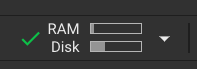


2. By each test case, e.g. Sensor, Camera Dark Frame, please press the play of each cell in sequence:
   -  **Query data**
   -  **Serials filter**
   -  **Plot**
   -  **Data table**

In [ ]:
#@title Project Configs<br></br> {run: "auto"}

Project='hk3' #@param ['sb3', 'hk3'] {type:'string',isTemplate: true}
Build='PROTO' #@param ['PROTO', 'PROTO1.0', "PROTO1.1", "EVT", "DVT", "PVT"] {type:'string',isTemplate: true}
Type='offline' #@param ['offline', 'offsite']
Start_Date='2022-10-15' #@param {type:'date',isTemplate: true}
Last_Date='2022-11-30' #@param {type:'date',isTemplate: true}
Latest_Data = True #@param {type: 'boolean'}


"""Query the Coex testing data and generates the plogs."""
from collections import defaultdict, namedtuple
from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from io import StringIO
from pathlib import Path
from time import gmtime, strftime
import argparse
import logging
import multiprocessing as mp
import pickle
import re
#import warnings

from bokeh.layouts import layout, column, Spacer
from bokeh.models import ColumnDataSource, Label, Div, HoverTool
from bokeh.palettes import Spectral10
from bokeh.plotting import figure, show, output_file, save
from google.colab import auth, data_table, files, output
from IPython.core.display import display
from IPython.display import HTML, Javascript
from oauth2client.client import GoogleCredentials
from plotly import subplots
from plotly.graph_objs import Heatmap, Layout, Figure
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pytz import timezone
import holoviews as hv
import numpy as np
import pandas as pd
import pexpect

# Try to filter out pandas error and warning
pd.options.mode.chained_assignment = None # default='warn'
warnings.filterwarnings('ignore', 'This pattern has match groups')
# Try to filter out no module named 'oauth2client.locked_file' error
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

PROJECT_CSV = namedtuple('project_csv', 'sensor logs factory')
CSV_FILES = {
    'offline':
    {
        'hk3': PROJECT_CSV('10qmCwoywSJhPlx6_rKuiSDKhY09oDBIY',
                           '19jYN9YKb4iEg1eW0PWuz3W4eTjevNae8',
                           '1mi5smeX5ixPcWAQ0CiYz4u8d2qyV-zmG'),
        'sb3': PROJECT_CSV('1iOhWh6vAPeihFOCTrac5A6aLKWj2_Pas',
                           '1MlbvmDKFB2SavB2Tm2fNgM1WKtFk9OG0',
                           '1X7gU2UrIj3j07q9uYWnJnJqDaG7Yj9yz'),
    },
    'offsite':
    {
        'hk3': PROJECT_CSV('1tkIwdsX5R2fHSu0d18HuCvd_qKvYtrPd',
                            '1vnQjGAPuJYJ8vK8LC7lJtMaYWXgxo8hZ',
                            '1qOmv2SfAM3VSgNVyi2saJfDkvQWjFJhB'),
        'sb3': PROJECT_CSV('130xrKM9SsQB_9z2B5saDX89iDXPeDwL2',
                            '1-tL2NXFXgQe_i7iXGwCIrA3adfmVs2TF',
                            '1W1eAfByRj1MEsggADGys2tVzQ-hhoap4'),
    }
    
}

class Table(Enum):
    """Contains the folder of google drive use for query."""
    SENSOR = 0
    LOGS = 1
    FACTORY = 2


class StatusError(IndexError):
    """Raised when the station data is empty."""


class Base():
    """Class definition for base function."""
    def GetSerialsList(src_df):
        """
        The complete serial list is in logs dataframe, since it collects all
        the log attachments, but test dataframe could miss some test data.
        """
        return src_df[src_df['serial'].notna()]['serial'].unique().tolist()

    def GetTestCasesList(src_df):
        return src_df[src_df['test_case'].notna()].test_case.unique().tolist()

    def GetTestItemsList(src_df):
        """
        The complete test items list is in test dataframe,
        since it contains all test items.
        """
        return src_df[src_df['test_item'].notna()].test_item.unique().tolist()

    def GetSensorsList(src_df):
        if 'sensor_name' in src_df.columns:
            return src_df[src_df['sensor_name'].notna()].sensor_name.unique().tolist()
        else:
            return None

    def FindMissingRaws(src_df, serials_list, test_cases_list,
                        test_items_list=None, sensors_list=None):
        if sensors_list:
            indices_list = ['serial', 'test_case', 'sensor_name']
            product_list = [serials_list, test_cases_list, sensors_list]
        elif test_items_list:
            indices_list = ['serial', 'test_case', 'test_item']
            product_list = [serials_list, test_cases_list, test_items_list]
        else:
            indices_list = ['serial', 'test_case']
            product_list = [serials_list, test_cases_list]

        src_df.set_index(indices_list, inplace=True)
        complete_index = pd.MultiIndex.from_product(product_list,
                                                    names=indices_list)
        missing_index = complete_index.difference(src_df.index)
        missing_df = pd.DataFrame(index=missing_index, columns=src_df.columns)
        missing_df.reset_index(inplace=True)
        src_df.reset_index(inplace=True)

        if sensors_list:
            for test_case in test_cases_list:
                if not test_items_list:
                    test_items_list = Base.GetTestItemsList(src_df)
                test_item_data = next(x for x in test_items_list if test_case in x)
                missing_df.loc[missing_df.test_case == test_case,
                               'test_item'] = test_item_data
        return missing_df

    def GetDataframeBySerial(src_df, serials):
        out_df = src_df.set_index(['serial'])
        out_df = out_df.loc[serials]
        return out_df.reset_index()

    def GetDataframeStatus(src_df):
        if src_df.empty:
            raise StatusError(f'There are no data in this station yet between {Start_Date} and {Last_Date}.')

    def FillMissingLogs(missing_df, logs_df):
        missing_serials_list = Base.GetSerialsList(missing_df)
        logs_source_df = Base.GetDataframeBySerial(logs_df,
                                                   missing_serials_list)
        missing_df.set_index(['serial', 'test_case'], inplace=True)
        logs_source_df.set_index(['serial', 'test_case'], inplace=True)
        missing_df.drop(logs_source_df.columns, axis=1, inplace=True)
        missing_df = missing_df.join(logs_source_df)
        logs_source_df.reset_index(inplace=True)
        missing_df.reset_index(inplace=True)
        return missing_df

    def FillTestItemOfMissingDataframe(missing_df, logs_df, test_cases_list, test_items_list, test_item_key=None, key_mask=''):
        for test_case in test_cases_list:
            if not test_item_key:
                test_item_key=test_case.replace(key_mask, '')
            sub_test_items = [x for x in test_items_list if test_item_key in x ]
            test_item_len = len(missing_df[missing_df['test_case'] == test_case])
            sub_test_items_count = int(test_item_len/len(sub_test_items))
            test_item_data = np.tile(sub_test_items, sub_test_items_count)
            missing_df.loc[missing_df.test_case == test_case,
                           'test_item'] = test_item_data
        return missing_df

    def FillDeviceConfigOfMissingDataframe(missing_df, logs_df):
        serials = missing_df[missing_df['device_config'].isna()].serial.unique().tolist()
        logs_df.set_index('serial', inplace=True)
        missing_df.set_index('serial', inplace=True)
        config_series=logs_df.loc[serials]['device_config'].dropna()
        config_df = config_series.reset_index()
        config_df.drop_duplicates(inplace=True)
        config_dict = config_df.to_dict('records')

        for item in config_dict:
            missing_df.loc[item['serial'], 'device_config'] = item['device_config']

        logs_df.reset_index(inplace=True)
        missing_df.reset_index(inplace=True)
        return missing_df

    def FillSensorNameOfMissingDataframe(missing_df, test_df, sensors_list):
        sensor_len = len(sensors_list)
        output_df = pd.DataFrame(columns=missing_df.columns)
        test_cases_list = Base.GetTestCasesList(test_df)
        missing_df.set_index('test_case', inplace=True)
        for test_case in test_cases_list:
            temp_df = missing_df.loc[test_case]
            temp_df.reset_index(inplace=True)
            temp_df_len = len(temp_df)
            temp_df = pd.concat([temp_df]*sensor_len)
            sensor_data = np.repeat(sensors_list, temp_df_len)
            temp_df['sensor_name'] = sensor_data
            output_df = output_df.append(temp_df, sort=False, ignore_index=True)

        missing_df.reset_index(inplace=True)
        return output_df

    def FillColumnsOfMissingDataframe(missing_df, logs_df, test_cases_list,
                                      test_items_list, test_item_key=None, key_mask=''):
        missing_df = Base.FillDeviceConfigOfMissingDataframe(missing_df, logs_df)

        # Fill station and build_phase
        station=logs_df[logs_df['station'].notna()].iloc[0]['station']
        build_phase=logs_df[logs_df['build_phase'].notna()].iloc[0]['build_phase']
        values={'station':station, 'build_phase':build_phase}
        missing_df.fillna(value=values, inplace=True)
        return missing_df

    def CreateMissingDataframe(test_df, logs_df, test_item_key=None, key_mask=''):
        merged_df = logs_df.merge(test_df, how='left')
        serials_list = Base.GetSerialsList(logs_df)
        test_cases_list = Base.GetTestCasesList(test_df)
        sensors_list = Base.GetSensorsList(test_df)
        test_items_list = Base.GetTestItemsList(test_df)

        missing_df = Base.FindMissingRaws(merged_df, serials_list,
                                          test_cases_list,
                                          test_items_list=test_items_list,
                                          sensors_list=sensors_list)
        missing_df = Base.FillMissingLogs(missing_df, logs_df)
        missing_df = Base.FillColumnsOfMissingDataframe(missing_df, logs_df,
                                                        test_cases_list,
                                                        test_items_list,
                                                        test_item_key=test_item_key,
                                                        key_mask=key_mask)
        return missing_df

    def MergeDataframes(df, missing_df, check_dup_cols):
        if Latest_Data:
            df.sort_values(by=['log_date', 'log_time'], ascending=True, inplace=True)
            df.dropna(subset=['test_item'], inplace=True)
            df.drop_duplicates(subset=check_dup_cols, keep='last', inplace=True)
            df = df.append(missing_df, sort=False)
            df.drop_duplicates(subset=check_dup_cols, keep='first', inplace=True)
            return df
        else:
            return df

    def MergeDataLogs(log_df, test_df):
        df = log_df.merge(
            test_df,
            how='left',
            on=['serial', 'test_case', 'build_phase', 'log_date', 'log_time'])
        return df

    def ProcessCameraData(test_df, logs_df, camera_name):
        src_df=logs_df.merge(test_df, how='left', on=['serial',
                                                      'test_case',
                                                      'build_phase'])
        camera_df=src_df[src_df.test_case.str.contains(camera_name)]
        # To fill missing dataframe, we need sub_test_df for specific camera data,
        # or we get useless data.
        sub_test_df = test_df[test_df.test_case.str.contains(camera_name)].dropna()

        missing_df = Base.CreateMissingDataframe(sub_test_df,
                                                 logs_df,
                                                 key_mask=camera_name)
        camera_df = Base.MergeDataframes(camera_df, missing_df, ['serial',
                                                                 'test_case',
                                                                 'test_item'])
        camera_df = camera_df.dropna(subset = ["test_item"])
        camera_df.sort_values(by=['test_item', 'serial'],
                              ascending=False, inplace=True)
        return camera_df

    def GetDeviceConfigList(src_df):
        """The device configs list in dataframe."""
        return src_df[src_df['device_config'].notna()] \
            ['device_config'].unique().tolist()

    def GetData(logs_df, latest_only):
        cache = {}
        if latest_only:
            for serial in logs_df.serial.unique():
                logs_df_by_serial = logs_df[logs_df.serial.str.contains(serial)]
                lastest_date = logs_df_by_serial.log_date.unique()[0]
                lastest_time = logs_df_by_serial[logs_df_by_serial.log_date.eq(lastest_date)].log_time.unique()[0]
                cache[serial] = (lastest_date, lastest_time)

            filter_logs_df = pd.DataFrame(columns=logs_df.columns)
            for serial, time in cache.items():
                filter_df = logs_df[logs_df.serial.str.contains(serial)
                                        & logs_df.log_date.eq(time[0])
                                        & logs_df.log_time.eq(time[1])]
                filter_logs_df = filter_logs_df.append(filter_df)

            return filter_logs_df
        else:
            return logs_df

    def GetData_Aux(logs_df, latest_only):
        cache = {}
        if latest_only:
            for serial in logs_df.serial.unique():
                logs_df_by_serial = logs_df[logs_df.serial.str.contains(serial)]
                lastest_date = logs_df_by_serial.log_date.unique()[0]
                lastest_time = logs_df_by_serial[logs_df_by_serial.log_date.eq(lastest_date)].log_time.unique()[0]
                cache[serial] = (lastest_date, lastest_time)

            filter_logs_df = pd.DataFrame(columns=logs_df.columns)

            for serial, time in cache.items():
                filter_df = logs_df[logs_df.serial.str.contains(serial)
                                        & logs_df.log_date.eq(time[0])]
                filter_logs_df = filter_logs_df.append(filter_df)
            return filter_logs_df
        else:
            return logs_df


class Drive():
    """Class definition for pull data from GDrive."""
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    external_colab = True

    def date_to_timestamp(year, month, date, time_zone='Asia/Shanghai'):
        tz = timezone(time_zone)
        timestamp = datetime(year, month, date)
        return tz.localize(timestamp).timestamp()

    def load_table(table, build_phase, station_pattern,
                   config_prefix=None, test_case_pattern=None,
                   test_item_pattern=None,
                   start_date=Start_Date, last_date=Last_Date):
        def get_timestamp(date):
            year, month, day = date.split('-')
            return Drive.date_to_timestamp(int(year), int(month), int(day)) * 1000

        # print('Query from CSV...', end='')
        id = None
        if table == Table.SENSOR:
            id = CSV_FILES[Type][Project].sensor
        elif table == Table.LOGS:
            id = CSV_FILES[Type][Project].logs
        elif table == Table.FACTORY:
            id = CSV_FILES[Type][Project].factory

        if Drive.external_colab:
            csv_file = Drive.drive.CreateFile({'id':id})
            data = csv_file.GetContentString()
            df = pd.read_csv(StringIO(data))
        else:
            data = Drive.drive.LoadFile(file_id=id)
            df = pd.read_csv(StringIO(data.decode('utf-8')))
        df = df[df['build_phase'].str.contains(build_phase)]

        if config_prefix:
            df = df[df['device_config'].str.match(f'^{config_prefix}')]

        start_date_wo_dash = int(start_date.replace('-',''))
        last_date_wo_dash = int(last_date.replace('-',''))
        start_ts_ms = get_timestamp(start_date)
        last_ts_ms = get_timestamp(last_date)
        if table == Table.SENSOR:
            # Drop the data out of the date conditions
            df = df[df['measurement_date_china'] >= int(start_date_wo_dash)]
            df = df[df['measurement_date_china'] <= int(last_date_wo_dash)]
            # seperate test_case to test_case + test_item
            df['test_item'] = df.test_case.apply(lambda x: re.search('TEST_(SENSOR.*|CAM[0-9]IMU[0-9]{1,3}.*|BTS.*)', x).group(1))
            df['test_case'] = df.test_case.apply(lambda x: re.search('_(SENSOR[0-9]+|CAM[0-9]IMU[0-9]{1,3}|BTS[0-9]+)_', x).group(1))
            df.rename(columns={
                'measurement_date_china': 'log_date',
                'measurement_time_china': 'log_time'},
                inplace=True)
            df.drop(columns=['device_config'], inplace=True)

        if table == Table.LOGS:
            # Drop the data out of the date conditions
            df = df[df['log_date'] >= start_date_wo_dash]
            df = df[df['log_date'] <= last_date_wo_dash]

            # Workaround for BTS log due to no station name included
            df['station'].fillna(value=station_pattern, inplace=True)
            
            df = df[df.station.notna() & df.station.str.contains(station_pattern)]
            df['station'] = df.station.apply(lambda x: re.search(f'({station_pattern})', x).group(1))
        
        if table == Table.FACTORY:
            # Drop the data out of the date conditions
            df = df[df['start_time_ms'] >= start_ts_ms]
            df = df[df['start_time_ms'] <= last_ts_ms]
            df = df[df.full_test_name.str.match(test_item_pattern)]
            df['test_case'] = df.full_test_name.apply(lambda x: re.search(test_case_pattern, x).group(1))
            df['test_item'] = df.full_test_name.apply(lambda x: re.search(test_item_pattern, x).group(2))
            df['test_date_time'] = df.start_time_ms.apply(lambda x: strftime('%Y-%m-%dT%H:%M:%S +0000', gmtime(x/1000)))
            df.drop(columns=['full_test_name', 'start_time_ms',
                             'device_config', 'station'], inplace=True)

        # print('Done!')
        return df

QueryData = Drive.load_table

class Station():
    """Class definition for query station data."""
    BUILD_PHASE = {
        'PROTO': 'PROTO',
        'PROTO1.0': 'P1',
        'PROTO1.1': 'P2',
        'EVT': 'EVT',
        'DVT': 'DVT',
        'PVT': 'PVT',
    }

    STATION = {
        'WC': f'C_{Project.upper()}_1_WiredCharging',
        'NFC': 'C_{Project.upper()}_2a_NfcAggressor',
        'CAM': 'C_{Project.upper()}_(.*)_(.*)(Cam|Vcm)',
        #'CAM': 'C_{Project.upper()}_(.*)_(.*)(Cam|Vcm)(.*)',
        'WLC': 'C_{Project.upper()}_3_WLC',
        'SENSOR': 'C_{Project.upper()}_4_Sensor',
    }

    def wired_charging_station(self) -> pd.DataFrame:
        wc_test_df = QueryData(Table.SENSOR, self.BUILD_PHASE[Build],
                               self.STATION['WC'])
        wc_test_df = wc_test_df[wc_test_df.test_case.str.contains('SENSOR902|SENSOR903')]
        wc_test_df = wc_test_df.sort_values(by=['log_date', 'log_time'], ascending=False)
        wc_test_df = wc_test_df.drop_duplicates(['serial', 'test_case',
                                                 'sensor_name', 'test_item', 'log_time'])
        Base.GetDataframeStatus(wc_test_df)

        wc_logs_df = QueryData(Table.LOGS, self.BUILD_PHASE[Build],
                               self.STATION['WC'])
        wc_logs_df = wc_logs_df.sort_values(by=['test_date_time'], ascending=False)
        wc_logs_df = wc_logs_df.drop_duplicates(['serial', 'test_case', 'test_date_time'])
        wc_logs_df = wc_logs_df[wc_logs_df.test_case.notna() & \
                                wc_logs_df.test_case.str.contains('SENSOR902|SENSOR903')]
        wc_logs_df = Base.GetData(wc_logs_df, Latest_Data)

        missing_wc_df = Base.CreateMissingDataframe(wc_test_df, wc_logs_df)
        wc_df = Base.MergeDataLogs(wc_logs_df, wc_test_df)
        wc_df = Base.MergeDataframes(
            wc_df, missing_wc_df, ['serial', 'test_case', 'test_item', 'sensor_name'])
        wc_df.sort_values(by=['test_item', 'serial'], ascending=False, inplace=True)
        wc_df.rename(columns={'val1_std': 'x', 'val2_std': 'y', 'val3_std': 'z'}, inplace=True)
        wc_df['full'] = wc_df['serial'] + '_' + wc_df['log_date'].map(str)
        return wc_df

    def nfc_station(self) -> dict:
        test_case_pattern = '^([A-Za-z0-9]+)_'
        test_item_pattern = '^CAM[R|F][0-9]{1}(.*)$'
        log_item_pattern = 'CAM[F|R][0-9]{1}RAWDARK'

        camera_test_df = QueryData(Table.FACTORY, self.BUILD_PHASE[Build],
                                   self.STATION['NFC'], None,
                                   test_case_pattern, test_item_pattern)
        camera_test_df = camera_test_df.sort_values(by=['test_date_time'], ascending=False)
        camera_test_df = camera_test_df.drop_duplicates(['serial', 'test_case', 'test_item'])
        Base.GetDataframeStatus(camera_test_df)

        camera_logs_df = QueryData(Table.LOGS, self.BUILD_PHASE[Build],
                                   self.STATION['NFC'])
        camera_logs_df = camera_logs_df.sort_values(by=['test_date_time'], ascending=False)
        camera_logs_df = camera_logs_df.drop_duplicates(['serial', 'test_case', 'test_date_time'])
        camera_logs_df['full'] = camera_logs_df['serial'] + '_' + camera_logs_df['log_date'].map(str)
        camera_lum_test_df = camera_test_df[camera_test_df.test_item.notna() & \
                                            camera_test_df.test_item.str.contains('LUMINANCE_WORST')].copy()
        # camera_lum_test_df['test_date_time']=camera_lum_test_df['test_date_time'].astype(str)
        # drop the inconsistan date time for merging data
        camera_lum_test_df.drop(columns=['test_date_time'], inplace=True)

        camera_lum_logs_df = camera_logs_df[camera_logs_df.test_case.notna() & \
                                            camera_logs_df.test_case.str.contains(log_item_pattern)].copy()
        camera_lum_logs_df.drop(camera_lum_logs_df[camera_lum_logs_df.test_case.str.contains('DARK900') ].index, inplace=True)

        columns = camera_lum_logs_df.merge(camera_lum_test_df, how='left',
                                           on=['serial', 'test_case', 'build_phase']).columns

        cam_test_cases_template = ['CAM{}RAWDARK190', 'CAM{}RAWDARK191']
        camera_id = ['Front', 'RearWide', 'RearTele', 'RearUltrawide']

        test_case_list = [test_case.format(id) for test_case in cam_test_cases_template for id in camera_id]

        merged_df = pd.DataFrame(columns=columns)

        process_camera_logs_df = Base.GetData(camera_lum_logs_df, Latest_Data)
        for test_case in test_case_list:
            merged_df = merged_df.append(Base.ProcessCameraData(camera_lum_test_df,
                                                                process_camera_logs_df,
                                                                test_case))
        merged_df = merged_df.reset_index()
        Base.GetDataframeStatus(merged_df)
        for idx, row in merged_df.iterrows():
            row.test_item = row.test_case[3:5] + '_' + row.test_item
            merged_df.iloc[idx] = row

        nfc_logs_df = camera_logs_df[camera_logs_df.test_case.notna() \
                          & camera_logs_df.test_case.str.contains('NFC')].copy()
        nfc_logs_df = Base.GetData(nfc_logs_df, Latest_Data)
        nfc_data_table = nfc_logs_df.append(merged_df)
        nfc_logs_df.append(merged_df)
        return {
            'merged_df': merged_df,
            'nfc_logs_df': nfc_logs_df,
            'nfc_data_table': nfc_data_table,
        }

    def camera_station(self) -> dict:
        test_case_pattern = '^([A-Za-z0-9]+)_'
        test_item_pattern = '^CAM(RearWide|RearTele|RearUltrawide|Front)(.*)$'
        log_item_pattern = 'CAM(RearWide|RearTele|RearUltrawide|Front)RAWDARK'

        camera_test_df = QueryData(Table.FACTORY, self.BUILD_PHASE[Build],
                                   self.STATION['CAM'], None,
                                   test_case_pattern, test_item_pattern)
        camera_test_df = camera_test_df.sort_values(by=['test_date_time'], ascending=False)
        camera_test_df = camera_test_df.drop_duplicates(['serial', 'test_case', 'test_item'])
        Base.GetDataframeStatus(camera_test_df)

        camera_logs_df = QueryData(Table.LOGS, self.BUILD_PHASE[Build],
                                   self.STATION['CAM'])
        camera_logs_df = camera_logs_df.sort_values(by=['test_date_time'], ascending=False)
        camera_logs_df = camera_logs_df.drop_duplicates(['serial', 'test_case', 'test_date_time'])
        camera_logs_df['full'] = camera_logs_df['serial'] + '_' + camera_logs_df['log_date'].map(str)
        camera_lum_test_df = camera_test_df[camera_test_df.test_item.notna() & \
                                            camera_test_df.test_item.str.contains('LUMINANCE_WORST')].copy()
        # camera_lum_test_df['test_date_time']=camera_lum_test_df['test_date_time'].astype(str)
        # drop the inconsistan date time for merging data
        camera_lum_test_df.drop(columns=['test_date_time'], inplace=True)

        camera_lum_logs_df = camera_logs_df[camera_logs_df.test_case.notna() & \
                                            camera_logs_df.test_case.str.contains(log_item_pattern)].copy()
        camera_lum_logs_df.drop(camera_lum_logs_df[camera_lum_logs_df.test_case.str.contains('DARK900') ].index, inplace=True)

        camera_lum_logs_df_by_station = camera_lum_logs_df.groupby('station')

        columns = camera_lum_logs_df.merge(camera_lum_test_df,
                                           how='left',
                                           on=['serial',
                                               'test_case',
                                               'build_phase']).columns

        cam_test_cases_template = [
            'CAM{}RAWDARK0',   'CAM{}RAWDARK900',
            'CAM{}RAWDARK103', 'CAM{}RAWDARK104', 'CAM{}RAWDARK105',
            'CAM{}RAWDARK106',
            'CAM{}RAWDARK132', 'CAM{}RAWDARK134', 'CAM{}RAWDARK136',
            'CAM{}RAWDARK203',
            'CAM{}RAWDARK880',
        ]

        # 2022.09.20(charleslin@) considering remove this later
        camera_id_map = {
            'Front': 'Front',
            'RearTele': 'RearTele',
            'RearWide': 'RearWide',
            'RearUltraWide': 'RearUltrawide',
        }

        cam_df = {}
        for group_name in camera_lum_logs_df_by_station.groups:
            pattern = re.compile(self.STATION['CAM'])
            result = pattern.match(group_name)
            station_name = result.group(1) # 2b~2e, 2m, 2v
            camera_name = result.group(2) # Front/RearWide/...
            cam_df[group_name] = {}
            if result is not None:
                cam_df[group_name]['station'] = station_name
                cam_df[group_name]['df'] = pd.DataFrame(columns=columns)
                # for station 2m and 2v,  group(2) is empty
                if camera_name:
                    cam_df[group_name]['id'] = camera_name
                    cam_test_cases_list = map(lambda x: x.format(camera_id_map[str(camera_name)]), cam_test_cases_template)

                    station_logs_df = camera_lum_logs_df_by_station.get_group(group_name)
                    process_camera_logs_df = Base.GetData(station_logs_df, Latest_Data)

                    # C_SB3_2m, mmW df
                    station_aux_df = camera_lum_logs_df_by_station.get_group(f'C_{Project.upper()}_2m_Cam')
                    station_aux_df = station_aux_df[station_aux_df.test_case.str.contains(camera_name)]
                    processed_station_aux_df = Base.GetData_Aux(station_aux_df, Latest_Data)
                    process_camera_logs_df = pd.concat([process_camera_logs_df, processed_station_aux_df])

                    # C_SB3_2v, VCM df
                    station_aux_df = camera_lum_logs_df_by_station.get_group(f'C_{Project.upper()}_2v_Vcm')
                    station_aux_df = station_aux_df[station_aux_df.test_case.str.contains(camera_name)]
                    processed_station_aux_df = Base.GetData_Aux(station_aux_df, Latest_Data)
                    process_camera_logs_df = pd.concat([process_camera_logs_df, processed_station_aux_df])

            for test_case in cam_test_cases_list:
                cam_df[group_name]['df'] = cam_df[group_name]['df'].append(
                    Base.ProcessCameraData(camera_lum_test_df,
                                           process_camera_logs_df,
                                           test_case))
            cam_df[group_name]['df'].sort_values(by=['test_item', 'serial'],
                                                 ascending=False, inplace=True)
        return cam_df

    def wireless_charging_station(self) -> pd.DataFrame:
        wlc_test_df = QueryData(Table.SENSOR, self.BUILD_PHASE[Build],
                                self.STATION['WLC'])
        wlc_test_df = wlc_test_df.sort_values(by=['log_date', 'log_time'], ascending=False)
        wlc_test_df = wlc_test_df.drop_duplicates(['serial', 'test_case',
                                                   'sensor_name', 'test_item',
                                                   'log_time'])
        wlc_test_df = wlc_test_df[wlc_test_df.test_case.str.contains('SENSOR902|SENSOR903')]
        Base.GetDataframeStatus(wlc_test_df)

        wlc_logs_df = QueryData(Table.LOGS, self.BUILD_PHASE[Build],
                                self.STATION['WLC'])
        wlc_logs_df = wlc_logs_df.sort_values(by=['test_date_time'], ascending=False)
        wlc_logs_df = wlc_logs_df.drop_duplicates(['serial', 'test_case', 'test_date_time'])
        wlc_logs_df = wlc_logs_df[wlc_logs_df.test_case.notna() & \
                                  wlc_logs_df.test_case.str.contains('SENSOR902|SENSOR903')]
        wlc_logs_df = Base.GetData(wlc_logs_df, Latest_Data)

        missing_wlc_df = Base.CreateMissingDataframe(wlc_test_df, wlc_logs_df)
        wlc_df = Base.MergeDataLogs(wlc_logs_df, wlc_test_df)
        wlc_df = Base.MergeDataframes(
            wlc_df, missing_wlc_df, ['serial', 'test_case', 'test_item', 'sensor_name'])
        wlc_df.sort_values(by=['test_item', 'serial'], ascending=False, inplace=True)
        wlc_df.rename(columns={'val1_std': 'x', 'val2_std': 'y', 'val3_std': 'z'}, 
                      inplace=True)
        wlc_df['full'] = wlc_df['serial'] + '_' + wlc_df['log_date'].map(str)
        return wlc_df

    def sensor_station(self) -> pd.DataFrame:
        sensor_test_df = QueryData(Table.SENSOR, self.BUILD_PHASE[Build],
                                   self.STATION['SENSOR'])
        sensor_test_df = sensor_test_df.sort_values(by=['log_date', 'log_time'], ascending=False)
        sensor_test_df = sensor_test_df.drop_duplicates(['serial', 'test_case',
                                                         'sensor_name', 'test_item',
                                                         'log_date', 'log_time'])
        sensor_test_df = sensor_test_df[~sensor_test_df.test_case.str.contains('SENSOR902|SENSOR903')]
        Base.GetDataframeStatus(sensor_test_df)

        sensor_logs_df = QueryData(Table.LOGS, self.BUILD_PHASE[Build],
                                   self.STATION['SENSOR'])
        sensor_logs_df = sensor_logs_df.sort_values(by=['test_date_time'], 
                                                    ascending=False)
        sensor_logs_df = sensor_logs_df.drop_duplicates(subset=['serial', 'test_case', 'test_date_time'], keep='last')
        sensor_logs_df = sensor_logs_df[sensor_logs_df.test_case.notna() & \
                                        sensor_logs_df.test_case.str.contains('SENSOR|BTS')]
 
        if 'SENSOR106' in sensor_logs_df['test_case'].unique():
            sensor_logs_mmw_df = sensor_logs_df[sensor_logs_df.test_case.str.contains('SENSOR106')]
            sensor_logs_df = sensor_logs_df[~sensor_logs_df.test_case.str.contains('SENSOR106')]
            sensor_logs_mmw_df = Base.GetData_Aux(sensor_logs_mmw_df, Latest_Data)
            sensor_logs_df = Base.GetData(sensor_logs_df, Latest_Data)
            sensor_logs_df = pd.concat([sensor_logs_df, sensor_logs_mmw_df])
        else:
            sensor_logs_df = Base.GetData(sensor_logs_df, Latest_Data)

        missing_df = Base.CreateMissingDataframe(sensor_test_df, sensor_logs_df)
        sensor_df = Base.MergeDataLogs(sensor_logs_df, sensor_test_df)
        sensor_df = Base.MergeDataframes(
            sensor_df, missing_df, ['serial', 'test_case', 'test_item', 'sensor_name'])
        sensor_df.sort_values(by=['test_item', 'serial'], ascending=False, inplace=True)
        sensor_df.rename(columns={'val1_std': 'x', 'val2_std': 'y', 'val3_std': 'z'}, 
                         inplace=True)
        # sensor_df['log_date'] = sensor_df['log_date'].dropna().astype('int64')
        sensor_df['full'] = sensor_df['serial'] + '_' + sensor_df['log_date'].map(str)
        return sensor_df

QueryStation = Station()

@dataclass
class SensorPlotly():
    """Class definition for coex sensor plot."""
    spec: float
    marginal: float
    zmax: float
    title: str
    multiaxes: bool
    zmin: float
    device_configs: list
    hover_x_title: str
    axis_settings = dict(tickfont=dict(size=10),
                                 tickangle=45,
                                 automargin=True)
    data_settings = {
        True: 'serial',
        False: 'full',
    }
    hover_columns_x = ['serial', 'test_item', 'x', 'device_config',
                       'tempature', 'battery', 'test_date_time',
                       'result', 'message']
    hover_columns_y = ['serial', 'test_item', 'y', 'device_config',
                       'tempature', 'battery', 'test_date_time',
                       'result', 'message']
    hover_columns_z = ['serial', 'test_item', 'z', 'device_config',
                       'tempature', 'battery', 'test_date_time',
                       'result', 'message']
    storage = {}

    def _ColorScale(self):
        critical = (self.spec - self.zmin) / (self.zmax - self.zmin)
        marginal_critical = (self.marginal - self.zmin) / (self.zmax - self.zmin)
        return [[0, 'grey'],
                [0.0001, 'lightblue'], 
                [critical, 'royalblue'], 
                [critical+0.0001, 'Gold'], 
                [marginal_critical, 'DarkOrange'], 
                [marginal_critical+0.0001, 'red'], 
                [1, 'darkred']
        ]

    def _BuildHeapmap(self, df_x, df_y, df_z, df_hover):
        return Heatmap(
            z=df_z,
            x=df_x,
            y=df_y,
            xgap=2,
            ygap=2,
            colorscale=self._ColorScale(),
            zmin = self.zmin,
            zmax = self.zmax,
            hoverinfo='text',
            text=df_hover
        )

    def _HoverInfo(self, x):
        output='SN: {}'.format(x[0]) \
             + '<br>TestCase: {}'.format(x[1]) \
             + '<br>{}: {}'.format(self.hover_x_title, x[2]) \
             + '<br>Config: {}'.format(x[3]) \
             + '<br>Temperature (Start/End): {} °C'.format(x[4]) \
             + '<br>Battery (Start/End): {}'.format(x[5]) \
             + '<br>Start Time: {}'.format(x[6])
        if isinstance(x[7], str) and 'done' not in x[7]:
            output = output + '<br>Result: {}'.format(x[7])
        if x[8]:
            output = output + '<br>Message: {}'.format(x[8])
        return output

    def _BuildTraceFigure(self, df):
        df_x = df[self.data_settings[Latest_Data]]
        df_y = df.test_item
        df_z = df.x
        hover = df[self.hover_columns_x].apply(lambda x: self._HoverInfo(x), axis=1)
        data = [
            self._BuildHeapmap(df_x=df[self.data_settings[Latest_Data]],
                               df_y=df.test_item, df_z=df.x, df_hover=hover)
        ]
        layout = Layout(
            title= {
                'text': self.title,
                'xanchor': 'center',
                'y': 0.95,
                'x': 0.5,
            },
            xaxis=self.axis_settings,
            yaxis=self.axis_settings,
            autosize=True,
            clickmode='event',
        )
        return Figure(data=data, layout=layout)

    def _BuildTracesFigure(self, df):
        hover_x = df[self.hover_columns_x].apply(lambda x: self._HoverInfo(x),
                                                 axis=1)
        hover_y = df[self.hover_columns_y].apply(lambda x: self._HoverInfo(x),
                                                 axis=1)
        hover_z = df[self.hover_columns_z].apply(lambda x: self._HoverInfo(x),
                                                 axis=1)

        fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.08,
                                     subplot_titles=('X-Axis',
                                                     'Y-Axis',
                                                     'Z-Axis'))

        # Default all data
        x_axis = self._BuildHeapmap(df_x=df[self.data_settings[Latest_Data]],
                                    df_y=df.test_item, df_z=df.x,
                                    df_hover=hover_x)
        y_axis = self._BuildHeapmap(df_x=df[self.data_settings[Latest_Data]],
                                    df_y=df.test_item, df_z=df.y,
                                    df_hover=hover_y)
        z_axis = self._BuildHeapmap(df_x=df[self.data_settings[Latest_Data]],
                                    df_y=df.test_item, df_z=df.z,
                                    df_hover=hover_z)
        fig.add_trace(x_axis, 1, 1)
        fig.add_trace(y_axis, 2, 1)
        fig.add_trace(z_axis, 3, 1)

        fig.update_layout(
            title= {
                'text': self.title,
                'xanchor': 'center',
                'y': 0.95,
                'x': 0.5,
            },
            xaxis = dict(self.axis_settings, visible = False),
            yaxis = self.axis_settings,
            xaxis2 = dict(self.axis_settings, visible = False),
            yaxis2 = self.axis_settings,
            xaxis3 = self.axis_settings,
            yaxis3 = self.axis_settings,
            autosize = True,
            height = 800,
        )
        return fig

    def _GetDataByDeviceConfig(self, df, device_config):
        filtered_df = df[df.device_config.str.match(f'^{device_config}$')]
        filtered_hover_x = filtered_df[self.hover_columns_x].apply(lambda x: self._HoverInfo(x), axis=1)
        filtered_hover_y = filtered_df[self.hover_columns_y].apply(lambda x: self._HoverInfo(x), axis=1)
        filtered_hover_z = filtered_df[self.hover_columns_z].apply(lambda x: self._HoverInfo(x), axis=1)
        return [ {'x':[filtered_df[self.data_settings[Latest_Data]],
                       filtered_df[self.data_settings[Latest_Data]],
                       filtered_df[self.data_settings[Latest_Data]]],
                  'y':[filtered_df.test_item,
                       filtered_df.test_item,
                       filtered_df.test_item],
                  'z':[filtered_df.x, filtered_df.y, filtered_df.z],
                  'text':[filtered_hover_x, filtered_hover_y, filtered_hover_z]}]

    def _AddDevicesConfigSelections(self, df):
        """Default show all data which the first 3 traces."""
        buttons = [dict(label='All Configs',
                   method='update',
                   args=self._GetDataByDeviceConfig(df, '.*'))
        ]

        for config in self.device_configs:
            buttons.append(
                dict(label=config,
                    method='update',
                    args=self._GetDataByDeviceConfig(df, config))
            )

        self.fig.update_layout(
            updatemenus=[
                dict(
                    active=0,
                    buttons=buttons,
                    direction='down',
                    pad={'r': 10, 't': 10},
                    showactive=True,
                    x=0.8,
                    xanchor='left',
                    y=1.25,
                    yanchor='top'
                ),
            ],
        )

    def Show(self, df, click_event=None):
        if self.multiaxes:
            self.fig = self._BuildTracesFigure(df)
        else:
            self.fig = self._BuildTraceFigure(df)
        self._AddDevicesConfigSelections(df)
        self.fig.show()

    @staticmethod
    def plot(df, setting, config, title):
        device_configs = Base.GetDeviceConfigList(df)
        sensor_plotly = SensorPlotly(spec=config['spec'], zmin=config['zmin'],
                                     zmax=config['zmax'], marginal=config['marginal'],
                                     title=title, multiaxes=setting['multiaxes'],
                                     device_configs=device_configs,
                                     hover_x_title=config['hover_x_title'])
        sensor_plotly.Show(df)

    @staticmethod
    def compute_diff(test_df, idle_df, multiaxes, columns):
        diff_df = pd.DataFrame(columns=columns).drop(
            columns=['val1_mean', 'val2_mean', 'val3_mean', 'val1_misc',
                     'val2_misc', 'val3_misc'])
        if not idle_df.empty and not test_df.empty:
            for index, test_row in test_df.iterrows():
                idle_rows = idle_df[(
                    idle_df[SensorPlotly.data_settings[Latest_Data]].str.contains(test_row[SensorPlotly.data_settings[Latest_Data]])
                    & idle_df.test_item.str.contains(test_row.test_item + '_Idle_Reference'))]
                if len(idle_rows) > 0:
                    idle_row = idle_rows.iloc[0]
                    diff_row = test_row.copy()
                    diff_row.drop(columns=['val1_mean', 'val2_mean',
                                           'val3_mean', 'val1_misc',
                                           'val2_misc', 'val3_misc'], inplace=True)

                    diff_row.test_item = 'Diff of ' + test_row.loc['test_item'] + '/Idle_Reference'
                    diff_row.x = abs(test_row.loc['val1_mean'] - idle_row.loc['val1_mean'])

                    if multiaxes:
                        diff_row.y = abs(test_row.loc['val2_mean'] - idle_row.loc['val2_mean'])
                        diff_row.z = abs(test_row.loc['val3_mean'] - idle_row.loc['val3_mean'])
                    diff_df = diff_df.append(diff_row)

        return diff_df

    @staticmethod
    def process(station_df):
        try:
            serials_filter = dropdown_data_serials.filter_df_by_selected_data(sensor_df.serial)
        except NameError:
            serials_filter = None

        try:
            configs_filter = dropdown_data_configs.filter_df_by_selected_data(sensor_df.device_config)
        except NameError:
            configs_filter = None

        without_reference_pattern = 'SENSOR|BTS\\d+_(.(?!_Idle_Reference))+$'
        test_case_pattern = 'SENSOR|BTS'
        settings = [
          {
            'sensor_name': 'Pressure Sensor',
            'multiaxes': False,
            'configs': [
            {
                'type': 'std',
                'spec': 0.04,
                'marginal': 0.1,
                'zmin': 0,
                'zmax': 0.14,
                'title': 'Pressure Sensor (MEAN_MOVSTD)',
                'hover_x_title': 'MEAN_MOVSTD',
            },
            {
                'type': 'mean_idle',
                'spec': 0.25,
                'marginal': 0.45,
                'zmin': 0,
                'zmax': 0.7,
                'title': 'Pressure Sensor (MEAN_IDLE_DELTA)',
                'hover_x_title': 'MEAN_IDLE_DELTA',
            }
            ],
        },
        {
            'sensor_name': 'ICM45631 Accelerometer-Uncalibrated',
            'multiaxes': True,
            'configs': [
            {
                'type': 'std',
                'spec': 10,
                'marginal': 20,
                'zmin': 0,
                'zmax': 30,
                'title': 'Accelerometer (STD)',
                'hover_x_title': 'STD',
            },
            {
                'type': 'mean_idle',
                'spec': 5,
                'marginal': 15,
                'zmin': 0,
                'zmax': 20,
                'title': 'Accelerometer (MEAN_IDLE_DELTA)',
                'hover_x_title': 'MEAN_IDLE_DELTA',
            },
            ],
        },
        {
            'sensor_name': 'ICM45631 Gyroscope-Uncalibrated',
            'multiaxes': True,
            'configs': [
            {
                'type': 'std',
                'spec': 300,
                'marginal': 500,
                'zmin': 0,
                'zmax': 800,
                'title': 'Gyroscope (STD)',
                'hover_x_title': 'STD',
            },
            {
                'type': 'mean_idle',
                'spec': 50,
                'marginal': 150,
                'zmin': 0,
                'zmax': 200,
                'title': 'Gyroscope (MEAN_IDLE_DELTA)',
                'hover_x_title': 'MEAN_IDLE_DELTA',
            },
            ],
        },
        {
            'sensor_name': 'MMC56X3X Magnetometer 0-Uncalibrated',
            'multiaxes': True,
            'configs': [
                {
                'type': 'std',
                'spec': 2,
                'marginal': 5,
                'zmin': 0,
                'zmax': 7,
                'hover_x_title': 'STD',
                'title': 'MMC56X3X Mag0 (STD)',
                },
                {
                'type': 'mean_idle',
                'spec': 3,
                'marginal': 6,
                'zmin': 0,
                'zmax': 9,
                'hover_x_title': 'MEAN_IDLE_DELTA',
                'title': 'MMC56X3X Mag0 (MEAN_IDLE_DELTA)',
                },
            ],
        },
        {
            'sensor_name': 'MMC56X3X Magnetometer 1-Uncalibrated',
            'multiaxes': True,
            'configs': [
                {
                'type': 'std',
                'spec': 2,
                'marginal': 5,
                'zmin': 0,
                'zmax': 7,
                'hover_x_title': 'STD',
                'title': 'MMC56X3X Mag1 (STD)',
                },
                {
                'type': 'mean_idle',
                'spec': 3,
                'marginal': 6,
                'zmin': 0,
                'zmax': 9,
                'hover_x_title': 'MEAN_IDLE_DELTA',
                'title': 'MMC56X3X Mag1 (MEAN_IDLE_DELTA)',
                },
            ],
            },
            {
                'sensor_name': 'MLX90632 FIR Temperature',
                'multiaxes': False,
                'configs': [
                {
                    'type': 'std',
                    'spec': 0.04,
                    'marginal': 0.1,
                    'zmin': 0,
                    'zmax': 0.14,
                    'title': 'BTS Sensor (OBJ_TEMP_STD)',
                    'hover_x_title': 'OBJ_TEMP_TD',
                },
                {
                    'type': 'std',
                    'spec': 0.04,
                    'marginal': 0.1,
                    'zmin': 0,
                    'zmax': 0.14,
                    'title': 'BTS Sensor (AMB_TEMP_STD)',
                    'hover_x_title': 'AMB_TEMP_STD',
                }
                ],
            },
        ]

        for setting in settings:
            data_filter = station_df.sensor_name.str.contains(setting['sensor_name']) \
                & station_df.test_case.str.contains(test_case_pattern)
            if serials_filter is not None:
                data_filter = data_filter & serials_filter
            if configs_filter is not None:
                data_filter = data_filter & configs_filter

            for config in setting['configs']:
                test_df = station_df[data_filter & station_df.test_item.str.contains(without_reference_pattern)]
                if test_df.empty:
                    raise TypeError("dataframe empty, please check sensor name: '\s'",
                                    setting['sensor_name'])

                if config['type'] == 'std':
                    if 'MLX90632' in setting['sensor_name']:
                      if 'AMB' in config['title']:
                        #test_df.rename(columns={'x': 'val1_std'}, inplace=True)
                        test_df.rename(columns={'val2_std': 'x'}, inplace=True)
                    
                    title = config['title']
                    SensorPlotly.plot(test_df, setting, config, title)
                    SensorPlotly.storage[title] = test_df

                else:
                    idle_df = station_df[data_filter & station_df.test_item.str.contains('Idle_Reference')]

                    diff_df = SensorPlotly.compute_diff(test_df, idle_df,
                                                        setting['multiaxes'],
                                                        station_df.columns)
                    if len(diff_df) > 0:
                        title = config['title']
                        SensorPlotly.plot(diff_df, setting, config, title)
                        SensorPlotly.storage[title] = diff_df

                        # Turn sensor summary to csv file
                        filename = datetime.now().strftime('%Y%m%d_' + 'sensor_summary.csv')
                        diff_df = diff_df.append(test_df)
                        diff_df = diff_df[['serial', 'test_date_time',
                                           'device_config', 'sensor_name',
                                           'test_item', 'x', 'y', 'z']]
                        diff_df.to_csv(filename, mode='a')


@dataclass
class CameraDarkFramePlotly(SensorPlotly):
    """Class definition for coex camera plot."""
    height: int = 900
    width: int = 1600
    hover_x_title: str = 'DELTA (IDLE)'
    average_pattern = 'DARK[0-9]{1,3}_LUMINANCE_WORST_AVG'
    delta_pattern = 'DARK[0-9]{1,3}_LUMINANCE_WORST_DELTA'
    max_pattern = 'DARK[0-9]{1,3}_LUMINANCE_WORST_MAX'
    min_pattern = 'DARK[0-9]{1,3}_LUMINANCE_WORST_MIN'
    hover_columns = ['serial', 'test_item', 'value', 'device_config',
                     'tempature', 'battery', 'test_date_time',
                     'result', 'message']

    def _ColorScale(self):
        length = self.zmax - self.zmin
        spec_position = (self.spec - self.zmin)/length
        zero_position = (0 - self.zmin)/length
        return [[0, 'lightgreen'],
                [zero_position, 'lightblue'],
                [spec_position, 'darkblue'],
                [spec_position+0.0001, 'red'],
                [1, 'darkred']
        ]

    def _HoverInfo(self, x):
        output='SN: {}'.format(x[0]) \
             + '<br>TestCase: {}'.format(x[1].split('_')[0]) \
             + '<br>{}: {}'.format(self.hover_x_title, x[2]) \
             + '<br>Config: {}'.format(x[3]) \
             + '<br>Temperature (Start/End): {} °C'.format(x[4]) \
             + '<br>Battery (Start/End): {}'.format(x[5]) \
             + '<br>Start Time: {}'.format(x[6])

        if isinstance(x[7], str) and 'pass' not in x[7]:
            output = output + '<br>Result: {}'.format(x[7])
            output = output + '<br>Message: {}'.format(x[8])
        return output

    def _BuildTracesFigure(self, df):
        average_df = df[df.test_item.str.contains(self.average_pattern)]
        #average_df.test_item = average_df.test_item.str.replace('_LUMINANCE_WORST_AVG', '')
        average_hover_df = average_df[self.hover_columns].apply(lambda x: self._HoverInfo(x), axis=1)
        average = self._BuildHeapmap(average_df[self.data_settings[Latest_Data]],
                                     average_df.test_item, average_df.value, average_hover_df)
        delta_df = df[df.test_item.str.contains(self.delta_pattern)]
        #delta_df.test_item = delta_df.test_item.str.replace('_LUMINANCE_WORST_DELTA', '')
        delta_hover_df = delta_df[self.hover_columns].apply(lambda x: self._HoverInfo(x), axis=1)
        delta = self._BuildHeapmap(delta_df[self.data_settings[Latest_Data]],
                                   delta_df.test_item, delta_df.value, delta_hover_df)
        max_df = df[df.test_item.str.contains(self.max_pattern)]
        #max_df.test_item = max_df.test_item.str.replace('_LUMINANCE_WORST_MAX', '')
        max_hover_df = max_df[self.hover_columns].apply(lambda x: self._HoverInfo(x), axis=1)
        cmax = self._BuildHeapmap(max_df[self.data_settings[Latest_Data]],
                                  max_df.test_item, max_df.value, max_hover_df)
        min_df = df[df.test_item.str.contains(self.min_pattern)]
        #min_df.test_item = min_df.test_item.str.replace('_LUMINANCE_WORST_MIN', '')
        min_hover_df = min_df[self.hover_columns].apply(lambda x: self._HoverInfo(x), axis=1)
        cmin = self._BuildHeapmap(min_df[self.data_settings[Latest_Data]],
                                  min_df.test_item, min_df.value, min_hover_df)

        fig = subplots.make_subplots(rows=4, cols=1, vertical_spacing=0.07,
                                     subplot_titles=('Average', 'Delta',
                                                     'Max', 'Min')
                                    )
        fig.add_trace(average, 1, 1)
        fig.add_trace(delta, 2, 1)
        fig.add_trace(cmax, 3, 1)
        fig.add_trace(cmin, 4, 1)
        fig.update_layout(
            title= {
                'text': self.title,
                'xanchor':'center',
                'y':0.95,
                'x':0.5,
            },
            xaxis = dict(self.axis_settings,visible = False),
            yaxis = self.axis_settings,
            xaxis2 = dict(self.axis_settings,visible = False),
            yaxis2 = self.axis_settings,
            xaxis3 = dict(self.axis_settings,visible = False),
            yaxis3 = self.axis_settings,
            xaxis4 = dict(self.axis_settings,visible = True),
            yaxis4 = self.axis_settings,
            autosize=True,
        )
        return fig

    def _GetDataByDeviceConfig(self, df, device_config):
        filtered_df = df[df.device_config.str.match(f'^{device_config}$')]
        filtered_average_df = filtered_df[filtered_df.test_item.str.contains(
            self.average_pattern)]
        average_hover_df = filtered_average_df[self.hover_columns].apply(
            lambda x: self._HoverInfo(x), axis=1)

        filtered_delta_df = filtered_df[filtered_df.test_item.str.contains(
            self.delta_pattern)]
        delta_hover_df = filtered_delta_df[self.hover_columns].apply(
            lambda x: self._HoverInfo(x), axis=1)

        filtered_max_df = filtered_df[filtered_df.test_item.str.contains(
            self.max_pattern)]
        max_hover_df = filtered_max_df[self.hover_columns].apply(
            lambda x: self._HoverInfo(x), axis=1)

        filtered_min_df = filtered_df[filtered_df.test_item.str.contains(
            self.min_pattern)]
        min_hover_df = filtered_min_df[self.hover_columns].apply(
            lambda x: self._HoverInfo(x), axis=1)

        return [ {'x':[filtered_average_df[self.data_settings[Latest_Data]],
                       filtered_delta_df[self.data_settings[Latest_Data]],
                       filtered_max_df[self.data_settings[Latest_Data]],
                       filtered_min_df[self.data_settings[Latest_Data]]],
                  'y':[filtered_average_df.test_item, filtered_delta_df.test_item,
                       filtered_max_df.test_item, filtered_min_df.test_item],
                  'z':[filtered_average_df.value, filtered_delta_df.value,
                       filtered_max_df.value, filtered_min_df.value],
                  'text':[average_hover_df, delta_hover_df,
                          max_hover_df, min_hover_df]}
        ]

        def _AddDevicesConfigSelections(self, df):
            buttons = [dict(label='All Configs',
                            method='update',
                            args=self._GetDataByDeviceConfig(df, '.*'))
            ]

            for config in self.device_configs:
                buttons.append(
                    dict(label=config,
                        method='update',
                        args=self._GetDataByDeviceConfig(df, config))
                )

            self.fig.update_layout(
                updatemenus=[
                    dict(
                        active=0,
                        buttons=buttons,
                        direction='down',
                        pad={'r': 10, 't': 10},
                        showactive=True,
                        x=0.8,
                        xanchor='left',
                        y=1.25,
                        yanchor='top'
                    ),
                ],
            )

    def Show(self, df):
        self.fig = self._BuildTracesFigure(df)
        self._AddDevicesConfigSelections(df)
        self.fig.show()


class NFCPlotly(SensorPlotly):
    """Class definition for coex nfc plot."""
    def _ColorScale(self):
        critical = (self.spec - self.zmin) / (self.zmax - self.zmin)
        return [[0, 'grey'],
                [0.0001, 'lightblue'],
                [critical, 'darkblue'],
                [critical+0.0001, 'red'],
                [1, 'darkred']
        ]

    def _BuildTraceFigure(self, df):
        df_x = df[self.data_settings[Latest_Data]]
        df_y = df.test_item
        df_z = df.x
        hover = df[self.hover_columns_x].apply(lambda x: self._HoverInfo(x),
                                               axis=1)
        data = [self._BuildHeapmap(df_x=df[self.data_settings[Latest_Data]],
                                   df_y=df.test_item, df_z=df.x,
                                   df_hover=hover)]
        layout = Layout(
            title= {'text': self.title,
                    'xanchor':'center',
                    'y':0.95,
                    'x':0.5,
            },
            xaxis=self.axis_settings,
            yaxis=self.axis_settings,
            autosize=True,
            clickmode='event')
        return Figure(data=data, layout=layout)

    def Show(self, df, click_event=None):
        self.fig = self._BuildTraceFigure(df)
        self.fig.show()

    def plots(self):
        df = nfc_df['nfc_logs_df'].copy()
        df['x'] = df['result']
        df['test_item'] = df['test_case']
        df['x'].replace(['PASS'], 0, inplace=True)
        df['x'].replace(['FAIL'], 1, inplace=True)
        df = df.sort_values(by=['serial', 'test_item'], ascending=False)
        self.Show(df)


class DropdownMenu():
    """Class definition for sensor filter."""
    def __init__(self, type_name, data):
        self.selected_data = []
        self.request_cam_data = {}
        self.type_name = type_name
        self.dropdown_data = {type_name: data}

    def show_readme(self):
        html = '''<div>
                    <h3>This field is to select specific device {item} to plot data.<br>
                    If there is selected {item}, then it will plot data of selected {item}.<br>
                    Otherwise, it will plot all data in the next cell.
                    </h3><br></div>'''

        return display(HTML(html.format(item=self.type_name)))

    def render_multiple_dropdown(self):
        optionsList = pd.Series(self.dropdown_data[self.type_name])
        callback_name = label = param_name = self.type_name
        val=''.join(self.request_cam_data)
        javascript_out = '''columnid_list = ['DUTR_TEST_NAME', 'DUTR_DEVICE_CONFIG', 'DUTR_BUILD_PHASE']
                            param_list = ['test_names', 'device_configs', 'build_phases']
                            var my_js_data = {};
                            const listenerChannel = new BroadcastChannel('channel');
                            listenerChannel.onmessage = (msg) => {
                            my_js_data = msg.data;
                            for(columnid in columnid_list){
                                var optionList = my_js_data[columnid_list[cvolumnid]]; 
                                var optionStr = '';
                                for (x in optionList){
                                optionStr += '<option value ='+ optionList[x] +'>' + optionList[x] +'</option>'}
                                $('#'+param_list[columnid]).empty().trigger("change");
                                document.getElementById(param_list[columnid]).innerHTML = optionStr;
                            }
                            }'''
        display(Javascript(javascript_out))
        html = ""
        html += '''<link href="https://cdnjs.cloudflare.com/ajax/libs/select2/4.0.4/css/select2.min.css" rel="stylesheet"/>
                <script src="https://ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min.js"></script>
                <script src="https://cdnjs.cloudflare.com/ajax/libs/select2/4.0.4/js/select2.min.js"></script>'''
        html += """<br><br><br><br><br>"""
        html += "<div id = '"+param_name+"Div'>"
        html += "<label style='font-size: 15px; font-weight: bold; margin-right: 8px; font-family: inherit;'> "+label+": </label>"
        html += "<select id = '"+param_name+"' multiple> </select>"
        html += "</div><br>"
        html += '''<script>'''
        html += '''$(document).ready(function(){'''
        html += "var onload_options = JSON.stringify({});".format(optionsList.to_json())
        html += '''var curr_val = "'''+val+'''";
                onload_options = onload_options.replace("'","\'");
                onload_options = JSON.parse(onload_options);
                var default_options = '';
                for (x in onload_options){
                    default_options += '<option value ='+ onload_options[x] +'>' + onload_options[x] +'</option>';}
                document.getElementById("'''+param_name+'''").innerHTML = default_options;
                $('#'''+param_name+'''').val(curr_val.split(",")).trigger('change');
                $('#'''+param_name+'''').on("change", function() {
                    if($('#'''+param_name+'''').val() == null) var selectedVal = "";
                    else var selectedVal = $(this).val().toString();
                    var param_name = document.querySelector('#'''+param_name+'''').id;
                    google.colab.kernel.invokeFunction("'''+callback_name+'''", [selectedVal, param_name], {});
                });'''
        html += "$('#"+param_name+"').select2({"
        html +="placeholder: 'Select "+label+"', width: '800px' }); }); </script>"
        return display(HTML(html))

    def set_selected_data(self, newVal, param_name):
        self.selected_data = newVal.split(',') if newVal else []

    def set_selected_cam_data(self, newVal, param_name):
        self.request_cam_data[param_name] = newVal.split(',') if newVal else []

    def get_selected_data(self):
        return self.selected_data

    def get_selected_cam_data(self):
        return self.request_cam_data

    def filter_df_by_selected_data(self, df):
        return df.isin(self.selected_data) if self.selected_data else None

    def filter_df_by_selected_cam_data(self, df, param_name):
        return df.serial.isin(self.request_cam_data[param_name]) \
            if self.request_cam_data[param_name] else None

    def register_callback(self):
        output.register_callback(self.type_name, self.set_selected_data)

    def register_cam_callback(self):
        output.register_callback(self.type_name, self.set_selected_cam_data)


class Dropdowntable():
    """Class definition for sensor table filter."""
    callback_name = 'table.on_change'
    master_dropdown_data = SensorPlotly.storage \
        if SensorPlotly.storage is not None else {}
    request_table = ''
    request_test_item = ''
    
    @staticmethod
    def show_readme():
        html = '''<div>
                    <h3>
                        This field is to select specific table and its test_item.<br>
                        You can get mean, min, max value.
                    </h3>
                    <br>
                    </div>'''

        return display(HTML(html))

    def render_multiple_dropdown(self):
        param_name1 = 'request_table'
        label1 = 'Table'
        param_name2 = 'request_test_item'
        label2 = 'Test item'
        optionsList = list(self.master_dropdown_data.keys())
        itemOptionsList = list(
            self.master_dropdown_data[self.request_table].test_item.unique()) if self.request_table else []
        val = self.request_table
        html = ''
        html += '''<link href="https://cdnjs.cloudflare.com/ajax/libs/select2/4.0.4/css/select2.min.css" rel="stylesheet"/>
                <script src="https://ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min.js"></script>
                <script src="https://cdnjs.cloudflare.com/ajax/libs/select2/4.0.4/js/select2.min.js"></script>'''
        html += "<div id = '"+param_name1+"Div' height = '100%'>"
        html += "<label style='font-size: 15px; font-weight: bold; margin-right: 8px; font-family: inherit;'> "+label1+": </label>"
        html += "<select id = '"+param_name1+"'> </select>"
        html += "</div><br>"
        html += "<div id = '"+param_name2+"Div'>"
        html += "<label style='font-size: 15px; font-weight: bold; margin-right: 8px; font-family: inherit;'> "+label2+": </label>"
        html += "<select id = '"+param_name2+"'> </select>"
        html += "</div><br>"
        html += """<br><br><br><br><br><br><br><br><br><br><br><br>"""
        html += '''<script>'''
        html += '''$(document).ready(function(){'''
        html += "var onload_options = {};".format(optionsList)
        html += '''var curr_val = "'''+val+'''";
                var default_options = '';
                for (x in onload_options){
                    default_options += '<option value =' + onload_options[x] + '>' + onload_options[x] + '</option>';}
                document.getElementById("'''+param_name1+'''").innerHTML = default_options;

                $('#'''+param_name1+'''').val(curr_val.split(",")).trigger('change');
                $('#'''+param_name1+'''').on("change", function() {
                    if($('#'''+param_name1+'''').val() == null) var selectedVal = "";
                    else var selectedVal = $(this).context.options[$(this).context.selectedIndex].innerText;
                    var param_name = document.querySelector('#'''+param_name1+'''').id;
                    google.colab.kernel.invokeFunction("'''+self.callback_name+'''", [selectedVal, param_name], {});
                });
                
                $('#'''+param_name2+'''').val(curr_val.split(",")).trigger('change');
                $('#'''+param_name2+'''').on("change", function() {
                    if($('#'''+param_name2+'''').val() == null) var selectedVal = "";
                    else var selectedVal = $(this).context.options[$(this).context.selectedIndex].innerText;
                    var param_name = document.querySelector('#'''+param_name2+'''').id;
                    google.colab.kernel.invokeFunction("'''+self.callback_name+'''", [selectedVal, param_name], {});
                });
                '''
        html += "$('#"+param_name1+"').select2({"
        html +="placeholder: 'Select "+label1+"', width: '800px' });"
        html += "$('#"+param_name2+"').select2({"
        html +="placeholder: 'Select "+label2+"', width: '800px' }); }); </script>"
        return display(HTML(html))

    def show_table(self, newVal, param_name):
        if param_name == 'request_table':
            self.request_table = newVal
            itemOptionsList = list(
                self.master_dropdown_data[self.request_table].test_item.unique()) if self.request_table else []
            js = ''
            js += 'var onload_item_options = {};'.format(itemOptionsList)
            js += '''
            var default_options = '';
            for (x in onload_item_options){
            default_options += '<option value =' + onload_item_options[x] + '>' + onload_item_options[x] + '</option>';}
            document.getElementById('request_test_item').innerHTML = default_options;
            '''
            display(Javascript(js))
        else:
            self.request_test_item = newVal

    def register_callback(self):
        output.register_callback(self.callback_name, self.show_table)

    def output_table(self):
        if self.request_table and self.request_test_item:
            request_df = SensorPlotly.storage[self.request_table]
            reqest_item_table = request_df[request_df.test_item.str.contains(self.request_test_item)]
            reqest_item_table = reqest_item_table.drop(
                columns=['sensor_name', 'project', 'build_phase',
                         'device_config', 'station','battery', 'filename',
                         'gs_path', 'log_date', 'log_time','time_std',
                         'test_case', 'test_item', 'elapsed',
                         'message','time_mean', 'result'])
            x_list = reqest_item_table.x.to_list()
            print(f'min_x: {min(x_list)}, max_x: {max(x_list)}, \
                    mean_x: {np.mean(x_list)}, std_x: {np.std(x_list)}')
            y_list = reqest_item_table.y.to_list()
            print(f'min_y: {min(y_list)}, max_y: {max(y_list)}, \
                    mean_y: {np.mean(y_list)}, std_y: {np.std(y_list)}')
            z_list = reqest_item_table.z.to_list()
            print(f'min_z: {min(z_list)}, max_z: {max(z_list)}, \
                    mean_z: {np.mean(z_list)}, std_z: {np.std(z_list)}')
        else:
            print('Please select a table and test item.')


class Summary():
    """Class definition for summary data table."""
    def print_data_table(df) -> pd.DataFrame:
        devices_count = df.serial.nunique()
        print(f'Tested devices: {devices_count}')
        max_date = max(df[df['log_date'].notna()].log_date.astype(int))
        min_date = min(df[df['log_date'].notna()].log_date.astype(int))
        print(f'Test period: {min_date} - {max_date}')
        return data_table.DataTable(df, num_rows_per_page=10,
                                    max_columns=40, max_rows=5000)

    def print_fail_data_table(df) -> pd.DataFrame:
        fail_df = df[['serial', 'device_config', 'test_case',
                      'test_date_time', 'result', 'message',
                      'battery',	'tempature']]
        fail_df = fail_df[fail_df['result'].str.contains('FAIL', na=False)]
        fail_df = fail_df.drop_duplicates(subset=['serial', 'device_config',
                                                  'test_date_time', 'test_case',
                                                  'message'])
        print('Total fail:', len(fail_df))
        return data_table.DataTable(fail_df, num_rows_per_page=10,
                                    max_columns=40, max_rows=5000)

    def check_fail_summary(df) -> pd.DataFrame:
        if fail_summay:
            return Summary.print_fail_data_table(df)
        else:
            return Summary.print_data_table(df)


"""
Pull sensor data from GCS
"""
class Gspull():
    """Class definition for pull data from GCS."""
    GSUTIL_URL = 'https://cloud.google.com/storage/docs/gsutil_install'
    UNZIP = '/usr/bin/unzip'
    RM = '/bin/rm'

    def _shell(cmd, errmsg=None):
        """Run a shell command and check for error.

        Args:
            cmd: Shell command to run.
            errmsg: Non-standard error message.

        Returns:
            Ouput of the command.

        Raises:
            Exception if non-zero return code.
        """
        logging.debug('|D| %s', cmd)
        out, ret = pexpect.run(cmd, withexitstatus=True)
        if ret:
            if errmsg is None:
                errmsg = '|E| Command: "{}" -> {}'.format(cmd, out)
            logging.error(errmsg)
            raise Exception(errmsg)
        return out.decode('utf-8')


    def gs_dataframe(args):
        """Create dataframes of GCS buckets from infile.

        Args:
            args: User arguments.

        Returns:
            Dataframe of GCS bucket ids and filenames.
        """
        # Create output directory
        outdir = Path(args.outdir) #.expanduser().resolve()
        outdir.mkdir(parents=True, exist_ok=True)
        # Read xlsx/csv input file of column (gs_path, filename)
        inf = Path(args.infile).expanduser().resolve()
        col_names = ['gs_path', 'filename']
        if inf.suffix == '.xlsx':
            dfr = pd.read_excel(inf, usecols=col_names, sheet_name=args.sheet)
        else:
            dfr = pd.read_csv(inf, usecols=col_names)
        # Make full-path filename
        joinpath = lambda x: str(outdir.joinpath(x))
        dfr['filename'] = dfr['filename'].apply(joinpath)
        # Selective pulls based on user arguments
        # -x/-y to exclude/include pulls
        mask = False
        contains = dfr.filename.str.contains
        if args.exclude:
            mask |=  contains('|'.join(args.exclude.split(',')))
        if args.include:
            mask |= ~contains('|'.join(args.include.split(',')))
        if not isinstance(mask, bool):
            dfr.drop(dfr[mask].index, inplace=True)
        # -l to limit number of files to pull
        if args.limit:
            dfr = dfr.head(args.limit)
        return dfr


    def gs_worker(gs_path, filename, keep=True, test=False):
        """Worker (for multiprocessin) to pull and unzip files from GCS.

        Args:
            gs_path: GCS bucket id.
            filename: File name for the pulled file.
            keep: True to keep the zip file pulled.
            test: True to test integrity of the gz filee without extracting them.

        Returns:
            Full path of the unzip directory.
            None if fail.
        """
        # Check if gsutil is installed
        cmd = 'which gsutil'
        errmsg = '|E| Please install gsutil from "{}"'.format(Gspull.GSUTIL_URL)
        gsutil = Gspull._shell(cmd, errmsg).strip()
        ret = None
        try:
            # Run gsutil
            cmd = '{} cp {} {}'.format(gsutil, gs_path, filename)
            Gspull._shell(cmd)
            # Run unzip
            rex = re.search(r'((.*)/\d{8}_\d{6}.*)_(TEST_.*)_coex.zip', filename)
            cmd = '{} {} \\*.gz -d {}'.format(
                Gspull.UNZIP + (' -t' if test else ''), filename, rex.group(2))
            Gspull._shell(cmd)
            ret = str(Path(rex.group(1))/rex.group(3))
        except:
            logging.error('|E| %s\t%s', gs_path, filename)
        # Remove zip file if asked
        if ret and not keep and Path(filename).exists():
            cmd = '{} {}'.format(Gspull.RM, filename)
            Gspull._shell(cmd)
        return ret


class Plib():
    """Class definition for bokeh plot."""
    hv.extension('bokeh')

    AX1_REX = re.compile('(Pressure|Orientation|Temperature)')
    PLOT_WIDTH = 500
    PLOT_HEIGHT = 300
    def _new_axes(dfi, yrex, name):
        """Convert generic y labels to sensor specific.

        Args:
            yrex: List of (pat, axes) to match.

        Returns:
            Relabelled dataframe, and y label.
        """
        axes = None
        for pat, axes in yrex:
            mex = pat.search(name)
            if mex:
                break
        if axes is None:
            axes = mex.groups()
        dfi = dfi.rename(columns={'c%d' % i: ax for i, ax in enumerate(axes)})
        return dfi, axes


    def _make_line(name, dfi, cfg):
        """Make a line plot.

        Args:
            name: Sensor name (used as title).
            dfi: Dataframe to be plotted.
            cfg: Plot configuration.

        Returns:
            Bokeh line plots.
        """
        # Make sure time is sorted
        dfi = dfi.sort_values('time')
        # Flexible axes and tooltips from pattern searches
        dfi, axes = Plib._new_axes(dfi, cfg['yrex'], name)
        tooltips = [('time', '@time{0.000}')] + [
                    (ax, '@{%s}{0.000}' % ax) for ax in axes]
        # Create figures for one sensor type
        figs = []
        tools = 'xpan,box_zoom,save,reset'
        for idx, axi in enumerate(axes):
            fig = figure(x_axis_label='Time (sec)', y_axis_label=axi,
                        tooltips=tooltips, tools=tools,
                        plot_width=Plib.PLOT_WIDTH, plot_height=Plib.PLOT_HEIGHT)
            fig.line(x='time', y=axi, source=ColumnDataSource(dfi),
                    line_width=2, color=Spectral10[idx])
            # No Bokeh link; Shared toolbar at above and controlling xpan
            fig.toolbar.logo = None
            if idx == 0:
                fig.title = name
                fig.toolbar_location = 'above'
            else:
                fig.title = ' '
                fig.toolbar_location = None
                fig.tools = figs[0].tools
                fig.x_range = figs[0].x_range
            # Show notes of mean & std
            text = 'mean: {:.3f}, std: {:.3f}'.format(
                dfi[axi].mean(), dfi[axi].std())
            stat = Label(x=10, y=5, x_units='screen', y_units='screen',
                text=text, text_font_size='12px',
                background_fill_color='white', background_fill_alpha=.7)
            fig.add_layout(stat)
            # Append figure(s) of one sensor type
            figs.append(fig)
        return figs


    def _make_box(name, dfi, cfg):
        """Make a box plot.

        Args:
            name: Sensor name (used as title).
            dfi: Dataframe to be plotted.
            cfg: Plot configuration.

        Returns:
            Bokeh line plots.
        """
        # Reset multiindex for Holoviews
        dfi.reset_index(dfi.index.names[:-1], inplace=True)
        # Flexible axes and tooltips from pattern searches
        dfi, axes = Plib._new_axes(dfi, cfg['yrex'], name)
        # Create figures for one sensor type
        els = []
        for idx, axi in enumerate(axes):
            box = hv.BoxWhisker(dfi, cfg['xdim'], axi)
            hover = HoverTool(tooltips=[cfg['xtip'], (axi, '@{%s}{0.000}' % axi)])
            box.opts(title=name if idx == 0 else '.',
                    default_tools=['pan', 'box_zoom', 'save', hover, 'reset'],
                    width=Plib.PLOT_WIDTH, height=Plib.PLOT_HEIGHT, xrotation=30,
                    box_fill_color=Spectral10[idx], fontsize={'xticks': 7},
                    ylabel=axi, labelled=[])
            els.append(box)

        plot = hv.NdLayout({axi: els[i] for axi, i in
                        zip(axes, range(len(axes)))}, kdims=name).cols(1)
        figs = hv.renderer('bokeh').get_plot(plot).state
        figs.children[0].toolbar.logo = None
        return figs


    def plot_it(ftype, dframe, cfg):
        """Line/Box plot using Bokeh/Holoviews.

        Args:
            ftype: Figure type (line/box)
            dframe: Dataframe to be plotted.
            cfg: Plot configuration.
        """
        # groupby sepecified at outer layer
        ## Line: project, build, serial/aggressor, iref
        ## Box: project, build, serial, aggressor, iref
        for idx, dfr in dframe.groupby(by=cfg['groupby']):
            # Sensor data of the same origin into one bundle
            bundle = defaultdict(list)
            for name in dfr.index.get_level_values(cfg['sensor']).unique():
                bundle[name.split()[0]].append(name)
            # Plot each bundle in one row
            rows = []
            for names in bundle.values():
                row = []
                for name in names:
                    if ftype == 'box':
                        dfi = dfr.xs(name, level=cfg['sensor']).loc[:, 'time':]
                        row.append(Plib._make_box(name, dfi, cfg))
                    elif ftype == 'line':
                        dfi = dfr.loc[idx + (name,), 'time':]
                        row.append(Plib._make_line(name, dfi, cfg))
                rows += [row, Spacer(height=60)]
            # Add a header
            title = '-'.join(idx)
            header = Div(text='<h2>{}</h2>'.format(title),
                        style={'text-align': 'center'})
            doc = column(header, layout(children=rows))
            if cfg['figdir'] is None:
                show(doc)
            else:
                outfile = Path(cfg['figdir']).joinpath(
                            '{}-{}.html'.format(title, ftype))
                logging.info('|I| Output file: %s', outfile)
                output_file(outfile, title=title)
                save(doc)


class Senfi():
    """Class definition for coex sensor data and plot."""
    # Set global logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    # Global variables
    PICKLE_FILE = '/tmp/sensor_dataframe.pickle'
    _MG = 1 / 0.0098
    _DEG = 180000 / np.pi
    _ECG_MV = 1/(2**21)*(1.2/21)*1e3
    CODE_DF = pd.DataFrame(
        columns=['code', 'multiplier'],
        data=[
    # Standard ID
    # https://android.googlesource.com/platform/frameworks/native/+/refs/heads/master/include/android/sensor.h#76
            [ 1,       _MG],        # Accel (Cal)   435 Hz
            [ 2,       1],          # Mag (Cal)     100 Hz
            [ 3,       1],          # Orientation   109 Hz
            [ 4,       _DEG],       # Gyro (Cal)    435 Hz
            [ 6,       1],          # Baro          25 Hz
    #        [11,       1],         # Rotation
            [14,       1],          # Mag (Unc)     100 Hz
            [16,       _DEG,],      # Gyro (Unc)
    #        [20,       1,],        # GeoMag        100 Hz
            [35,       _MG,],       # Accel (Unc)   435 Hz
            [37,       1,],         # PPG
            [39,       _ECG_MV,],   # ECG
    # TODO: Custom sensors maybe product-specific.
            [65538,    1],
            [65539,    1],
            [65540,    1],
            [33172002, 1],          # IMU Temp      1.7 Hz
            [33172003, 1],          # Baro Temp     25 Hz
            [33172004, 1],          # Mag Temp
        ]).set_index('code')
    # read_csv arguments for different sensors
    _CMAX = 3
    _COLS = ['code', 'fullname', 'timestamp',
            *['c{}'.format(i) for i in range(_CMAX)]]
    _TYPE = [('code', np.int32), ('timestamp', np.int64),
            *[('c{}'.format(i), np.float64) for i in range(_CMAX)]]
    CSV_ARGS = [
        ('sensors', dict(usecols=[2, 3, 4, 5, 6, 7], names=_COLS[:6],
            dtype=dict(_TYPE[:5]), converters={'fullname': str})),
        # PPG: 37.0 TS: 467069638549 Data: 89.000000 76.000000 50.000000
        #      -12.000000 3552.000000 3531.000000
        ('ppg_data', dict(sep=' ', usecols=[1, 2, 3, 5, 6, 7], names=_COLS[:6],
            dtype=dict(_TYPE[:5]), converters={'fullname': lambda x: 'PPG'},
            engine='python', skiprows=1, skipfooter=3, index_col=False)),
        # ECG: 39.0 TS: 1069311971892 Data: -172.000000
        ('ecg_data', dict(sep=' ', usecols=[1, 2, 3, 5], names=_COLS[:4],
            dtype=dict(_TYPE[0:3]), converters={'fullname': lambda x: 'ECG'},
            engine='python', skiprows=1, skipfooter=3, index_col=False)),
    ]
    # Dataframe column names based on sensor types
    REAL_COLS = [
        (re.compile(r'(Pressure|Orientation|Temperature)'), None),
        (re.compile(r'(PPG)'), ('PD12_Green', 'PD3_Red', 'PD3_IR')),
    #                            'PD3_IR_prox', 'PD12_ambient', 'PD3_ambient')),
        (re.compile(r'(ECG)'), ('ADC',)),
        (re.compile(r'(.*)'), ('x', 'y', 'z')),
    ]

    def __init__(self, args):
        """Init routine to store args, and prepare output directory.

        Args:
            args: User arguments.
        """
        self.args = args
        # Create outdir if not already.
        args.outdir = Path(args.outdir).expanduser().resolve() / 'senfi'
        args.outdir.mkdir(parents=True, exist_ok=True)
        # Create figures directory
        figdir = None
        if args.outform:
            figdir = args.outdir / 'figures'
            figdir.mkdir(parents=True, exist_ok=True)
        self.plot_cfg = {
            'figdir': figdir,
            'sensor': 'fullname',
            'yrex': self.REAL_COLS,
        }

    def read_csv(self, infile):
        """Read all csv files in .gz format in subdirectory.

        Args:
            infile: .gz file or directory containing .gz files.
                    This must conform to EECoexer generated log path.

        Returns:
            MultiIndex dataframe containing all sensor data under infile.
        """
        def _read_frames(paths):
            # CSV file format: code, fullname, timestamp, data...
            frames = []
            for pat, args in self.CSV_ARGS:
                args = args.copy()
                names = args['names']
                # Workaround: usecols falsely assumes NaN if first row has missing column
                if pat == 'sensors':
                    skipcols = list(range(2))
                    args['names'] = ['_{}'.format(i) for i in skipcols] + names
                    args['usecols'] = skipcols + args['usecols']
                for path in filter(lambda x: pat in str(x), paths):
                    try:
                        frames.append(pd.read_csv(path, **args)[names])
                    except EOFError as exc:
                        logging.error('|E| Failed to read %s -> %s', path, exc)
                    except ValueError as exc:
                        logging.error('|E| Incorrect CSV format %s -> %s', path, exc)
            return frames

        # infile may be a file or directory
        inf = Path(infile).expanduser().resolve()
        paths = [inf]
        if inf.is_dir() :
            paths = list(inf.rglob('*.gz'))
        # Read csv, and concat all dataframes
        ## MultiIndex extracted from path
        idx_names = ['project', 'serial', 'build', 'aggressor', 'iref', 'fullname']
        frames = _read_frames(paths)
        rex = re.compile(r'\d{8}_\d{6}_(.+)_(.+)_(.+)/TEST_[a-zA-Z]+(.*)/(.*?(?:sensors|data))')
        keys = [rex.search(str(path)).groups() for path in paths]
        if not self.args.band:
            fun = lambda x: x if x[-1].startswith('Idle') else (
                            x[:-1] + ('sensors',) if 'sensors' in x[-1] else (
                            x[:-1] + ('ppg_data',) if 'ppg_data' in x[-1] else (
                            x[:-1] + ('ecg_data',))))
            keys = map(fun, keys)
        dfr = pd.concat(frames, keys=keys, names=idx_names[:-1])
        dfr = dfr.swaplevel('serial', 'build')
        # Add 'fullname' to MultiIndex
        dfr = dfr.set_index('fullname', append=True).swaplevel()
        dfr.sort_index(inplace=True)
        # Add time column in sec
        ## groupby (project, build, serial, aggressor, iref, fullname)
        for idx, dfi in dfr.groupby(by=dfr.index.names[:-1]):
            tmin = dfi['timestamp'].min()
            dfr.loc[idx, 'timestamp'] = (dfi['timestamp'] - tmin) / 10**9
        # index: project, build, serial, aggressor, iref, fullname, None
        # column: code, time, ...
        return dfr.rename(columns={'timestamp': 'time'})

    def _get_dirlist(self):
        """Prepare directory list dataframe with column (gs_path, filename).
            gs_path is empty for local directories.

        Returns:
            Dataframe of (gs_path, filename)
        """
        args = self.args
        inf = Path(args.infile).expanduser().resolve()
        if inf.suffix in ('.xlsx', '.csv'):
            # Read xlsx/csv input file of column (gs_path, filename).
            dfr = Gspull.gs_dataframe(args)
        else:
            # Find all .gz files under infile directory.
            paths = filter(lambda x: x.suffix == '.gz', inf.rglob('*'))
            dfr = pd.DataFrame({
                    'gs_path': '',
                    'filename': [str(path.parent) for path in paths]})
            self._select_data(dfr, False)
        dfr.drop_duplicates(inplace=True)
        return dfr

    def _select_data(self, dfr, index=True):
        """Select data to process/plot based on user arguments.

        Args:
            dfr: Dataframe to be filtered.
            index: True/False to search in index/column

        Returns:
            Dataframe after filtering.
        """
        args = self.args
        if index:
            contains = dfr.index.get_level_values('aggressor').str.contains
        else:
            contains = dfr['filename'].str.contains
        # -x/-y to exclude/include aggressor/serial
        mask = False
        if args.exclude:
            mask |=  contains('|'.join(args.exclude.split(',')))
        if args.include:
            mask |= ~contains('|'.join(args.include.split(',')))
        # -s to select sensor type
        if index and args.sensor:
            contains = dfr.index.get_level_values('fullname').str.contains
            mask |= ~contains('|'.join(args.sensor.split(',')))
        if not isinstance(mask, bool):
            dfr.drop(dfr[mask].index, inplace=True)
        return dfr

    def _process_data(self, dfr):
        """Process data - raw, calibrated, or idle mean.

        Args:
            dfr: Dataframe to be processed.

        Returns:
            Dataframe after data processing.
        """
        args = self.args
        # Column names after (code, time, ...)
        cols = dfr.columns.tolist()[2:]
        # -w to use raw data
        if not args.raw:
            dfr = dfr.join(self.CODE_DF, on='code')
            dfr = dfr.assign(**{c: dfr[c] * dfr['multiplier'] for c in cols})
            newbie = dfr[dfr['multiplier'].isna()].index.get_level_values('fullname')
            if newbie.any():
                logging.debug('Unknown types: %s', newbie.unique())
            dfr.dropna(inplace=True, subset=['multiplier'])
            dfr.drop(columns='multiplier', inplace=True)
        # -c to use calibrated data
        names = dfr.index.get_level_values('fullname').unique()
        for name in filter(lambda x: x.endswith('-Uncalibrated'), names):
            if not args.calibrated:
                name = name.split('-')[0]
            if name in names:
                dfr.drop(index=name, level='fullname', inplace=True)
        # -m to substract idle mean
        if args.imean:
            names = ['project', 'build', 'serial', 'aggressor', 'fullname']
            for idx, dfi in dfr.groupby(by=names):
                if (dfi.index.get_level_values(
                    'iref').str.contains('Idle_Reference_sensors').any()):
                    idx1 = idx[0:-1] + ('Idle_Reference_sensors', idx[-1])
                    dfr.loc[dfi.index, cols] -= dfi.loc[idx1, cols].mean()
        return dfr

    def _write_csv(self, dfr):
        """Write .csv files groupby sensor types.

        Args:
            dfr: Dataframe to be written.
        """
        figdir = self.plot_cfg['figdir']
        for idx, dfi in dfr.groupby(by=dfr.index.names[:-1]):
            filename = figdir.joinpath('{}.csv'.format('-'.join(idx)))
            logging.debug('Writing csv files: %s', filename)
            dfi.loc[:,'time':].to_csv(filename, index=False)

    def _worker(self, gs_path, filename):
        """Mutiprocessing workers to process each device/aggressor in parallel.

        Args:
            gs_path: GCS bucket id. None a for local file.
            filename: directory or zip file name containing .gz sensor data.

        Returns:
            MultiIndex dataframe containing all sensor data.
        """
        # Read log files as csv into dataframe.
        logging.info('|I| Processing %s', filename)
        # Pull .zip file from GCS if gs_path specified.
        if gs_path:
            filename = Gspull.gs_worker(gs_path, filename)
            if filename is None:
                return pd.DataFrame()
        try:
            dfr = self.read_csv(filename)
        except ValueError:
            return pd.DataFrame()
        # Process data based on input arguments.
        dfr = self._process_data(dfr)
        # Plot line if asked (done by worker in parallel).
        if self.args.figure == 'line':
            self.plot_cfg['groupby'] = dfr.index.names[:5]
            Plib.plot_it('line', dfr, self.plot_cfg)
        return dfr

    def pardo(self):
        """Spawn multiprocessing workers for each device/aggressor.

        Returns:
            MultiIndex dataframe containing all sensor data.
        """
        args = self.args
        # Try to load pickle if no input file specified.
        if args.infile is None and Path(self.PICKLE_FILE).exists():
            logging.info('Read dataframe from %s', self.PICKLE_FILE)
            with open(self.PICKLE_FILE, 'rb') as fid:
                dfr = pickle.load(fid)
            dfr = self._select_data(dfr)
            # Run in single process, not as efficient.
            if args.figure == 'line':
                self.plot_cfg['groupby'] = dfr.index.names[:5]
                Plib.plot_it('line', dfr, self.plot_cfg)
        else:
            # Get directories with qualified .gz files.
            ## Retrieve from GCS if an xlsx/csv file is specified.
            dir_df = self._get_dirlist()
            # Multiprocessing pool workers
            with mp.Pool(min(mp.cpu_count(), len(dir_df))) as mpl:
                frames = mpl.starmap(self._worker, dir_df.values.tolist())
            dfr = pd.concat(frames)
            # Pickle it to save time during development
            if args.pickle:
                with open(self.PICKLE_FILE, 'wb') as fid:
                    pickle.dump(dfr, fid, pickle.HIGHEST_PROTOCOL)
        if args.outform == 'csv':
            self._write_csv(dfr)
        # Boxplot if asked.
        if args.figure == 'box':
            xdim = ['serial', 'aggressor']
            xtip = ('Aggressor', 'SENSOR@aggressor')
            if args.agg_ax:
                xdim = ['aggressor', 'serial']
                xtip = ('Serial', '@serial')
            self.plot_cfg.update({
                'xdim': xdim,
                'xtip': xtip,
                'groupby': ['project', 'build', xdim[0], 'iref'],
            })
            Plib.plot_it('box', dfr, self.plot_cfg)
        return dfr

    @staticmethod
    def filter_data():
        """filter senfi dataframe."""
        try:
            serials_filter = dropdown_data_senfi_serials.filter_df_by_selected_data(senfi_df.serial)
        except NameError:
            serials_filter = None

        try:
            testcases_filter = dropdown_data_senfi_testcases.filter_df_by_selected_data(senfi_df.test_case)
        except NameError:
            testcases_filter = None

        senfi_filter = senfi_df.station.str.contains('C_C10_1_WiredCharging|C_C10_4_Sensor')

        if serials_filter is not None:
            senfi_filter = senfi_filter & serials_filter
        
        if testcases_filter is not None:
            senfi_filter = senfi_filter & testcases_filter
        
        senfi_filter = senfi_df[senfi_filter]
        senfi_filter = senfi_filter[['gs_path', 'filename']].drop_duplicates()

        # Ensure senfi filter not contain all the devices
        if serials_filter is None and testcases_filter is None:
            senfi_filter = pd.DataFrame()
        
        senfi_filter.to_csv('senfi.csv', index=False)

        # Cleanup tmp folder before senfi plot it
        !rm -rf /tmp/senfi

    @staticmethod
    def download_data():
        if Path('/tmp/senfi/figures').exists:
            senfi_filename = '/tmp/senfi.zip'

            !rm -f '/tmp/senfi.zip' >/dev/null 2>&1
            !zip -rjq /tmp/senfi.zip /tmp/senfi/figures >/dev/null 2>&1
            !sleep 3

            try:
                files.download(senfi_filename)
            except FileNotFoundError:
                senfi_filename = None

    @staticmethod
    def main():
        """Argument parsing."""
        parser = argparse.ArgumentParser(
            description='Plot sensor data generated by EECoexer',
            formatter_class=argparse.RawDescriptionHelpFormatter,)
        parser.add_argument('-i', '--infile', default=None,
            help='This specifies the input directory/file. '
                'INFILE could be a directory or an .xlsx/.csv file. '
                'For a directory, senfi would search for all .gz files '
                'under the subdirectory assuming they are sensor data files '
                'generated by EECoxer. For an .xlsx/.csv file, it must contain '
                'a worksheet with two columns gs_paths and filename, '
                'where gs_path is the GCS bucket id and filename is the name of '
                'the zip file created by OLOG.')
        parser.add_argument('-s', '--sheet', default=0, type=int,
            help='Valid only if INFILE is an .xlsx file. It could be a number '
                '(0, 1, ...) or a sheet name (DVT1.0, EVT1.0, ...).')
        parser.add_argument('-w', '--raw', action='store_true',
            help='Use raw data without unit conversion. This applies only to '
                'accelerometer (converting to milli-gravity) and gyroscope '
                '(converting to milli-degree/second).')
        parser.add_argument('-c', '--calibrated', action='store_true',
            help='Use calibrated data, default is to use uncalibrated data.')
        parser.add_argument('-m', '--imean', action='store_true',
            help='Subtract idle reference mean from each sensor data. '
                'This does not apply to temperature and orientation sensor.')
        parser.add_argument('-l', '--limit', default=0, type=int,
            help='Limit the number of buckets to pull from GCS. '
                'This is a convenience option during development, '
                'since an .xlsx file may contain thousands of buckets, '
                'which would jam your local drive.')
        parser.add_argument('-x', '--exclude', default=None,
            help='Exclude those with matching pattern.')
        parser.add_argument('-y', '--include', default=None,
            help='Include those with matching pattern.')
        parser.add_argument('-r', '--sensor', default=None,
            help='Include sensor types. EXLUDE/INCLUDE/SENSOR are regular '
                'expressions to exclude/include aggressor types, and/or '
                'include sensor types. These are convenient if you just '
                'want to plot a subset of aggressors and/or sensors.')
        parser.add_argument('-b', '--band', action='store_true',
            help='Separate RF/WiFi bands/channels if so configured.')
        parser.add_argument('-f', '--figure', default=None,
            help='Figure type, currently only line plot and box plot are '
                'supported.')
        parser.add_argument('-a', '--agg_ax', action='store_true',
            help='For box plot only. If specified, the box plot would use '
                '(aggressor, serial) as the x-axis, instead of the usual '
                '(serial, aggressor).')
        parser.add_argument('-o', '--outdir', default='/tmp',
            help='Output directory')
        parser.add_argument('-t', '--outform', default=None,
            help='Output format, currently only html and csv are supported.')
        parser.add_argument('-p', '--pickle', action='store_true',
            help='For development only. Run Python pickle to save dataframe '
                'for next run.')
        # Parse arguments and run multiprocessing on each device/aggressor
        args = parser.parse_args(['--infile', '/content/senfi.csv',
                                  '--figure', Figure_Type,
                                  '--outform', Outform_Type])
        Senfi(args).pardo()

##Sensor Post Analysis

In [ ]:
#@title Filter {vertical-output: true, display-mode: 'form'}

sensor_df = QueryStation.sensor_station()
dropdown_data_serials = DropdownMenu('Serial', sensor_df.serial.unique())
#dropdown_data_serials.show_readme()
dropdown_data_serials.render_multiple_dropdown()
dropdown_data_serials.register_callback()

dropdown_data_configs = DropdownMenu('Config', sensor_df.device_config.unique())
#dropdown_data_configs.show_readme()
dropdown_data_configs.render_multiple_dropdown()
dropdown_data_configs.register_callback()

In [ ]:
#@title Plots
    
SensorPlotly.process(sensor_df)

In [ ]:
#@title Data table

fail_summay = True #@param {type:'boolean'}
Summary.check_fail_summary(sensor_df)

In [ ]:
#@title Barometer Diff table

# try:
#   from colabtools.interactive_table import Create as DataTable
# except:
#   from google.colab.data_table import DataTable

# PrintSummary(pressure_diff_df)
# df = pressure_diff_df.drop(columns=['log_date','log_time', 'measurement_date_china', 'measurement_time_china'])
# DataTable(df, max_columns=30, max_rows=60000)

##BTS Post Analysis

In [ ]:
#@title Filter {vertical-output: true, display-mode: 'form'}

sensor_df = QueryStation.sensor_station()
dropdown_data_serials = DropdownMenu('Serial', sensor_df.serial.unique())
#dropdown_data_serials.show_readme()
dropdown_data_serials.render_multiple_dropdown()
dropdown_data_serials.register_callback()

dropdown_data_configs = DropdownMenu('Config', sensor_df.device_config.unique())
#dropdown_data_configs.show_readme()
dropdown_data_configs.render_multiple_dropdown()
dropdown_data_configs.register_callback()

In [ ]:
#@title Plots
    
SensorPlotly.process(sensor_df)

In [ ]:
#@title Data table

fail_summay = True #@param {type:'boolean'}
Summary.check_fail_summary(sensor_df)

##Camera NFC Post Analysis

In [ ]:
#@title Plots

nfc_df = QueryStation.nfc_station()
device_configs = Base.GetDeviceConfigList(nfc_df['merged_df'])
nfc_plotly = NFCPlotly(spec=0, zmin=0, zmax=1, title='Camera NFC',
                       multiaxes=False, device_configs=device_configs,
                       hover_x_title='Value', marginal=None)
nfc_plotly.plots()

camera_plotly = CameraDarkFramePlotly(spec=10, zmin=-1, zmax=15,
                                        title='CAM For 190, 191 Dark NFC',
                                        device_configs=device_configs,
                                        multiaxes=True, marginal=None)
camera_plotly.Show(nfc_df['merged_df'])

In [ ]:
#@title Data table

fail_summay = False #@param {type: 'boolean'}
Summary.check_fail_summary(nfc_df['nfc_data_table'])

##Camera Dark Frame Post Analysis

In [ ]:
#@title Filter {vertical-output: true, display-mode: 'form'}

# This field is to select specific device serials to plot data
# If there is selected serial, then it will plot data of selected serials.
# Otherwise, it will plot all data in the next cell.

cam_df = QueryStation.camera_station()
dropdown_data_cams = {}
for _, cam_data in cam_df.items():
    if not cam_data['df'].empty:
        cam = 'CAM' + cam_data['id']
        cam_menu = DropdownMenu(cam, cam_data['df'].serial.unique())
        cam_menu.render_multiple_dropdown()
        cam_menu.request_cam_data.setdefault(cam, [])
        cam_menu.register_cam_callback()
        dropdown_data_cams[cam] = cam_menu

In [ ]:
#@title Plots

for group_name, cam_data in cam_df.items():
    if not cam_data['df'].empty:
        victim ='CAM' + cam_data['id']
        title=f'{victim} Dark Frame'

        try: 
            serials_filter = dropdown_data_cams[victim].filter_df_by_selected_cam_data(cam_data['df'], victim)
        except NameError:
            serials_filter = None

        if serials_filter is not None:
            cam_data['df'] = cam_data['df'][serials_filter]
        device_configs = Base.GetDeviceConfigList(cam_data['df'])
        camera_plotly = CameraDarkFramePlotly(spec=10, zmin=-1,
                                              zmax=15, title=title,
                                              device_configs=device_configs,
                                              multiaxes=True, marginal=None)
        camera_plotly.Show(cam_data['df'])

In [ ]:
#@title Data table

fail_summay = True #@param {type: 'boolean'}

camera_df = None
for cam_data in cam_df.values():
    if camera_df is None:
        camera_df = cam_data['df']
    else:
        camera_df = camera_df.append(cam_data['df'])
camera_df.sort_values(by=['test_item', 'serial'], ascending=False, inplace=True)
Summary.check_fail_summary(camera_df)

## Wired Charging Post Analysis

In [ ]:
#@title Plots

wc_df = QueryStation.wired_charging_station()
SensorPlotly.process(wc_df)

In [ ]:
#@title Data table

fail_summay = False #@param {type: 'boolean'}
Summary.check_fail_summary(wc_df)

### Offsite plot

In [ ]:
#@title Query Database

def CreateMissingDataframe(test_df, logs_df, test_item_key=None, key_mask=''):
  merged_df=logs_df.merge(test_df, how='left')
  serials_list = GetSerialsList(logs_df)
  test_cases_list = GetTestCasesList(test_df)
  sensors_list = GetSensorsList(test_df)
  test_items_list = GetTestItemsList(test_df)

  missing_df = FindMissingRaws(merged_df, serials_list, test_cases_list, test_items_list=test_items_list, sensors_list=sensors_list)
  missing_df = FillMissingLogs(missing_df, logs_df)
  missing_df = FillColumnsOfMissingDataframe(missing_df, logs_df, test_cases_list, test_items_list, test_item_key=test_item_key, key_mask=key_mask)

  return missing_df


test_case_pattern='^([A-Za-z0-9]+)_'
test_item_pattern='^[A-Za-z0-9]+_(.+)$'
station_pattern='C_R4_1_WiredCharging' #@param {type:'string'}

@dataclasses.dataclass
class WiredChargingPlotly:
  spec: float
  zmax: float
  title: str
  multiaxes: bool
  zmin: float
  height: int
  width: int
  axis_settings: dict

  def _BuildHeapmap(self, df_x, df_y, df_z, df_hover):
    return Heatmap(
        z=df_z,
        x=df_x,
        y=df_y,
        xgap=2,
        ygap=2,
        zmin = self.zmin,
        zmax = self.zmax,
        hoverinfo='x+y+z+text',
        text=df_hover,
    )

  def _BuildTraceFigure(self, df):
    df_hover = df[['result', 'message']].apply(lambda x: 'Result: {}<br>Message: {}'.format(x[0], x[1]), axis=1)
    data = [self._BuildHeapmap(df.serial, df.test_item, df.value, df_hover)]
    
    layout = Layout(
        title=self.title,
        xaxis = self.axis_settings,
        yaxis = self.axis_settings,
        height=self.height,
        width=self.width,
    )
    return Figure(data=data, layout=layout)

  def Show(self, df):
    fig = self._BuildTraceFigure(df)
    fig.show()

wc_test_df = QueryData(Table.FACTORY, Project, BUILD_PHASE[Build], station_pattern, test_case_pattern=test_case_pattern, 
                                         test_item_pattern=test_item_pattern)

wc_logs_df = QueryData(Table.LOGS, Project, BUILD_PHASE[Build], station_pattern)

# get latest one
wc_bench_test_df = wc_test_df[wc_test_df.test_item.notna() & wc_test_df.test_item.str.contains('bench')].copy()
wc_bench_test_df = wc_bench_test_df.sort_values(by=['test_date_time'], ascending=False)
wc_bench_test_df = wc_bench_test_df.drop_duplicates(['serial', 'test_case', 'test_item'])
wc_bench_test_df.drop(columns='test_date_time', inplace=True)

wc_logs_df = wc_logs_df.sort_values(by=['test_date_time'], ascending=False)
wc_logs_df = wc_logs_df.drop_duplicates(['serial', 'test_case'])

victim='RAM105'
aggressor='n[0-9]+'
wc_ram_fr1_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

victim='RAM106'
aggressor='n[0-9]+'
wc_ram_fr2_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

victim='RAM'
aggressor='GSM'
wc_ram_gsm_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

aggressor='802_11'
wc_ram_wifi_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

aggressor='UMTS'
wc_ram_umts_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

aggressor='LTE'
wc_ram_lte_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

misc_aggerssors=['CPU', 'GPU', 'media', 'idle']
wc_ram_misc_df = pandas.DataFrame(columns=wc_ram_gsm_df.columns)
for aggressor in misc_aggerssors:
  wc_ram_misc_df = wc_ram_misc_df.append(ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor))


victim='UFS105'
aggressor='n[0-9]+'
wc_ufs_fr1_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

victim='UFS106'
aggressor='n[0-9]+'
wc_ufs_fr2_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

victim='UFS'
aggressor='GSM'
wc_ufs_gsm_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

aggressor='802_11'
wc_ufs_wifi_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

aggressor='UMTS'
wc_ufs_umts_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

aggressor='LTE'
wc_ufs_lte_df = ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor)

misc_aggerssors=['CPU', 'GPU', 'media', 'idle']
wc_ufs_misc_df = pandas.DataFrame(columns=wc_ram_gsm_df.columns)
for aggressor in misc_aggerssors:
  wc_ufs_misc_df = wc_ufs_misc_df.append(ProcessUfsRamDataframe(wc_bench_test_df, wc_logs_df, victim, aggressor))

wc_df = wc_ram_gsm_df.append(wc_ram_fr1_df).append(wc_ram_fr2_df).append(wc_ram_wifi_df).append(wc_ram_umts_df).append(wc_ram_lte_df).append(wc_ram_misc_df)
wc_df = wc_df.append(wc_ufs_gsm_df).append(wc_ufs_fr1_df).append(wc_ufs_fr2_df).append(wc_ufs_wifi_df).append(wc_ufs_umts_df).append(wc_ufs_lte_df).append(wc_ufs_misc_df)

In [ ]:
#@title RAM Plots
try:
  %create_tabs  GSM, FR1, FR2, WiFi, UMTS, LTE, CPU GPU Media Idle
  %switch_to_tab GSM
except:
  pass
victim='RAM'
aggressor='GSM'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                title=title, multiaxes=multiaxes,
                                height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ram_gsm_df)

try:
  %switch_to_tab FR1
except:
  pass
victim='RAM'
aggressor='FR1'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ram_fr1_df)

try:
  %switch_to_tab FR2
except:
  pass
victim='RAM'
aggressor='FR2'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ram_fr2_df)

try:
  %switch_to_tab WiFi
except:
  pass
victim='RAM'
aggressor='WiFi'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ram_wifi_df)



try:
  %switch_to_tab UMTS
except:
  pass
victim='RAM'
aggressor='UMTS'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ram_umts_df)

try:
  %switch_to_tab LTE
except:
  pass
victim='RAM'
aggressor='LTE'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=1200
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ram_lte_df)

try:
  %switch_to_tab CPU GPU Media Idle
except:
  pass
victim='RAM'
aggressor='CPU|GPU|media|idle'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=800
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)

wc_plotly.Show(wc_ram_misc_df)

In [ ]:
#@title UFS Plots
try:
  %create_tabs  GSM, FR1, FR2, WiFi, UMTS, LTE, CPU GPU Media Idle
  %switch_to_tab GSM
except:
  pass
victim='UFS'
aggressor='GSM'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ufs_gsm_df)

try:
  %switch_to_tab FR1
except:
  pass
victim='UFS'
aggressor='FR1'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ufs_fr1_df)

try:
  %switch_to_tab FR2
except:
  pass
victim='UFS'
aggressor='FR2'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ufs_fr2_df)

try:
  %switch_to_tab WiFi
except:
  pass
victim='UFS'
aggressor='WiFi'
spec=1000
zmin=0
zmax=3000
title=f'Wired Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ufs_wifi_df)

try:
  %switch_to_tab UMTS
except:
  pass
victim='UFS'
aggressor='UMTS'
spec=1000
zmin=0
zmax=2000
title=f'Wired Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ufs_umts_df)

try:
  %switch_to_tab LTE
except:
  pass
victim='UFS'
aggressor='LTE'
spec=1000
zmin=0
zmax=2000
title=f'Wired Charging {victim} ({aggressor})'
height=1200
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wc_plotly.Show(wc_ufs_lte_df)

try:
  %switch_to_tab CPU GPU Media Idle
except:
  pass
victim='UFS'
aggressor='CPU|GPU|media|idle'
spec=1000
zmin=0
zmax=2000
title=f'Wired Charging {victim} ({aggressor})'
height=800
width=1600
multiaxes=True

wc_plotly = WiredChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)

wc_plotly.Show(wc_ufs_misc_df)

In [ ]:
#@title Query data table

try:
  from colabtools.interactive_table import Create as DataTable
except:
  from google.colab.data_table import DataTable

PrintSummary(wc_df)
DataTable(wc_df)

#wc_bench_test_df.drop(columns='test_date_time', inplace=True)
merged_df=wc_logs_df.merge(wc_bench_test_df, how='left')
DataTable(merged_df, max_columns=30, max_rows=60000)

## Wireless Charging Post Analysis

In [ ]:
#@title Plots

wlc_df = QueryStation.wireless_charging_station()
SensorPlotly.process(wlc_df)

In [ ]:
#@title Data table

fail_summay = False #@param {type: 'boolean'}
Summary.check_fail_summary(wlc_df)

### Offsite plot


In [ ]:
#@title Query Database
test_case_pattern='^([A-Za-z0-9]+)_'
test_item_pattern='^[A-Za-z0-9]+_(.+)$'
station_pattern='C_3_WLC'

@dataclasses.dataclass
class WirelessChargingPlotly:
  spec: float
  zmax: float
  title: str
  multiaxes: bool
  zmin: float
  height: int
  width: int
  axis_settings: dict

  def _BuildHeapmap(self, df_x, df_y, df_z, df_hover):
    return Heatmap(
        z=df_z,
        x=df_x,
        y=df_y,
        xgap=2,
        ygap=2,
        zmin = self.zmin,
        zmax = self.zmax,
        hoverinfo='x+y+z+text',
        text=df_hover,
    )

  def _BuildTraceFigure(self, df):
    df_hover = df[['result', 'message']].apply(lambda x: 'Result: {}<br>Message: {}'.format(x[0], x[1]), axis=1)
    data = [self._BuildHeapmap(df.serial, df.test_item, df.value, df_hover)]
    
    layout = Layout(
        title=self.title,
        xaxis = self.axis_settings,
        yaxis = self.axis_settings,
        height=self.height,
        width=self.width,
    )
    return Figure(data=data, layout=layout)

  def Show(self, df):
    fig = self._BuildTraceFigure(df)
    fig.show()

wlc_test_df = QueryData(Table.FACTORY, Project, BUILD_PHASE[Build], station_pattern, test_case_pattern=test_case_pattern, 
                                         test_item_pattern=test_item_pattern)

wlc_logs_df = QueryData(Table.LOGS, Project, BUILD_PHASE[Build], station_pattern)

# get latest one
wlc_bench_test_df = wlc_test_df[wlc_test_df.test_item.notna() & wlc_test_df.test_item.str.contains('bench')].copy()
wlc_bench_test_df = wlc_bench_test_df.sort_values(by=['test_date_time'], ascending=False)
wlc_bench_test_df = wlc_bench_test_df.drop_duplicates(['serial', 'test_case', 'test_item'])
wlc_bench_test_df.drop(columns='test_date_time', inplace=True)

wc_logs_df = wc_logs_df.sort_values(by=['test_date_time'], ascending=False)
wc_logs_df = wc_logs_df.drop_duplicates(['serial', 'test_case'])

victim='RAM105'
aggressor='n[0-9]+'
wlc_ram_fr1_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

victim='RAM106'
aggressor='n[0-9]+'
wlc_ram_fr2_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

victim='RAM'
aggressor='GSM'
wlc_ram_gsm_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

aggressor='802_11'
wlc_ram_wifi_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

aggressor='UMTS'
wlc_ram_umts_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

aggressor='LTE'
wlc_ram_lte_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

misc_aggerssors=['CPU', 'GPU', 'media', 'idle']
wlc_ram_misc_df = pandas.DataFrame(columns=wlc_ram_gsm_df.columns)
for aggressor in misc_aggerssors:
  wlc_ram_misc_df = wlc_ram_misc_df.append(ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor))

victim='UFS105'
aggressor='n[0-9]+'
wlc_ufs_fr1_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

victim='UFS106'
aggressor='n[0-9]+'
wlc_ufs_fr2_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

victim='UFS'
aggressor='GSM'
wlc_ufs_gsm_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

aggressor='802_11'
wlc_ufs_wifi_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

aggressor='UMTS'
wlc_ufs_umts_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

aggressor='LTE'
wlc_ufs_lte_df = ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor)

misc_aggerssors=['CPU', 'GPU', 'media', 'idle']
wlc_ufs_misc_df = pandas.DataFrame(columns=wlc_ram_gsm_df.columns)
for aggressor in misc_aggerssors:
  wlc_ufs_misc_df = wlc_ufs_misc_df.append(ProcessUfsRamDataframe(wlc_bench_test_df, wlc_logs_df, victim, aggressor))

wlc_df = wlc_ram_gsm_df.append(wlc_ram_fr1_df).append(wlc_ram_fr2_df).append(wlc_ram_wifi_df).append(wlc_ram_umts_df).append(wlc_ram_lte_df).append(wlc_ram_misc_df)
wlc_df = wlc_df.append(wlc_ufs_gsm_df).append(wlc_ufs_fr1_df).append(wlc_ufs_fr2_df).append(wlc_ufs_wifi_df).append(wlc_ufs_umts_df).append(wlc_ufs_lte_df).append(wlc_ufs_misc_df)

In [ ]:
#@title RAM Plots
try:
  %create_tabs  GSM, FR1, FR2, WiFi, UMTS, LTE, CPU GPU Media Idle
  %switch_to_tab GSM
except:
  pass
victim='RAM'
aggressor='GSM'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_gsm_df)

try:
  %switch_to_tab FR1
except:
  pass
victim='RAM'
aggressor='FR1'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_fr1_df)

try:
  %switch_to_tab FR2
except:
  pass
victim='RAM'
aggressor='FR2'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_fr2_df)

try:
  %switch_to_tab WiFi
except:
  pass
victim='RAM'
aggressor='WiFi'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_wifi_df)

try:
  %switch_to_tab UMTS
except:
  pass
victim='RAM'
aggressor='UMTS'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_umts_df)

try:
  %switch_to_tab LTE
except:
  pass
victim='RAM'
aggressor='LTE'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=1200
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_lte_df)

try:
  %switch_to_tab CPU GPU Media Idle
except:
  pass
victim='RAM'
aggressor='CPU|GPU|media|idle'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=800
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ram_misc_df)

In [ ]:
#@title UFS Plots
try:
  %create_tabs  GSM, FR1, FR2, WiFi, UMTS, LTE, CPU GPU Media Idle
  %switch_to_tab GSM
except:
  pass
victim='UFS'
aggressor='GSM'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_gsm_df)

try:
  %switch_to_tab FR1
except:
  pass
victim='UFS'
aggressor='FR1'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_fr1_df)

try:
  %switch_to_tab FR2
except:
  pass
victim='UFS'
aggressor='FR2'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_fr2_df)

try:
  %switch_to_tab WiFi
except:
  pass
victim='UFS'
aggressor='WiFi'
spec=1000
zmin=0
zmax=3000
title=f'Wireless Charging {victim} ({aggressor})'
height=400
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_wifi_df)
try:
  %switch_to_tab UMTS
except:
  pass
victim='UFS'
aggressor='UMTS'
spec=1000
zmin=0
zmax=2000
title=f'Wireless Charging {victim} ({aggressor})'
height=600
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_umts_df)

try:
  %switch_to_tab LTE
except:
  pass
victim='UFS'
aggressor='LTE'
spec=1000
zmin=0
zmax=2000
title=f'Wireless Charging {victim} ({aggressor})'
height=1200
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_lte_df)

try:
  %switch_to_tab CPU GPU Media Idle
except:
  pass
victim='UFS'
aggressor='CPU|GPU|media|idle'
spec=1000
zmin=0
zmax=2000
title=f'Wireless Charging {victim} ({aggressor})'
height=800
width=1600
multiaxes=True

wlc_plotly = WirelessChargingPlotly(spec=spec, zmin=zmin, zmax=zmax, 
                                      title=title, multiaxes=multiaxes,
                                      height=height, width=width, axis_settings=DEFAULT_AXIS_SETTINGS)
wlc_plotly.Show(wlc_ufs_misc_df)

In [ ]:
#@title Query Database

try:
  from colabtools.interactive_table import Create as DataTable
except:
  from google.colab.data_table import DataTable

PrintSummary(wlc_df)
DataTable(wlc_df)

# Revision

Revision Note:
- v0.5.11
  - Plot with station and camera id controll.
  